# Projet de tarification assurance auto

Ce projet exploite les jeux de données de référence en actuariat : freMTPL2freq (Fréquence) et freMTPL2sev (Sévérité / Coût).

1. Objectifs du projet:

Ce projet propose une approche moderne de la modélisation de la prime pure en utilisant le dataset freMTPL2. L'objectif de ce projet est de comparer les outils classiques en actuariat (GLM Poisson/ Gamma) aux outils de machine learning actuels et de regarder les enjeux éthiques de ces modèles performants.

2. Méthodologie:

Notre approche se décompose en trois phases techniques : 

Préparation des données (Data Engineering) :Séparation et nettoyage des jeux de données Fréquence et Sévérité.
Feature Engineering : Création de variables synthétiques pour maximiser le pouvoir prédictif.

Stratégie de Modélisation :
      Approche Baseline (GLM) : Modélisation canonique avec loi de Poisson (Fréquence) et loi Gamma (Coût moyen).
      Approche Machine Learning : Implémentation de modèles non-linéaires (Random Forest, XGBoost, LightGBM) pour capter les interactions complexes.

Audit d'équité : Mesure de la discrimination algorithmique (ex: Disparate Impact) pour s'assurer de la conformité éthique du tarif proposé.


## 1. Chargement des données

### 1.1 Import

Pour commencer, importons les packages nécessaires.

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import gdown
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
import lightgbm as lgb
import time as time
import shap
import catboost
import sklearn
sklearn.set_config(enable_metadata_routing=True)
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, TargetEncoder, StandardScaler, FunctionTransformer, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import PoissonRegressor, GammaRegressor, TweedieRegressor
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, d2_tweedie_score, mean_absolute_error, make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference
from catboost import CatBoostRegressor

C:\Users\lucas\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Importation de nos dataset Fréquence et Sévérité.

In [7]:
url_freq = "https://it.drive.google.com/uc?export=download&id=1XGYYuKaxFUlHY3C5To7B0l_lVeGJSmjX"
url_sev = "https://it.drive.google.com/uc?export=download&id=1jyMMpXqJHV7ufyB2tHhBByt5PzBYkrfw"

data_freq = pd.read_csv(url_freq, sep=',', on_bad_lines='skip')
data_sev = pd.read_csv(url_sev, sep=',', on_bad_lines='skip')

Nous créons une copie des dataset. Cela permet d'effectuer les transformations tout en conservant les données brutes intactes pour référence ou comparaison.

In [8]:
df_freq = data_freq.copy()
df_sev = data_sev.copy()

### 1.2 Aperçu initial

Vérification des premières lignes de notre dataset fréquence pour vérifier le bon chargement de nos données.

In [9]:
df_freq.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82
1,3.0,1,0.77,D,5,0,55,50,B12,Regular,1217,R82
2,5.0,1,0.75,B,6,2,52,50,B12,Diesel,54,R22
3,10.0,1,0.09,B,7,0,46,50,B12,Diesel,76,R72
4,11.0,1,0.84,B,7,0,46,50,B12,Diesel,76,R72


Analyse des statistiques descriptives pour détecter d'éventuelles valeurs aberrantes

In [10]:
df_freq.describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99])

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
count,6.780130e+05,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000
mean,2.621857e+06,0.053247,0.528750,6.454631,7.044265,45.499122,59.761502,1792.422405
std,1.641783e+06,0.240117,0.364442,2.050906,5.666232,14.137444,15.636658,3958.646564
min,1.000000e+00,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000
1%,1.993424e+04,0.000000,0.008219,4.000000,0.000000,20.000000,50.000000,10.000000
25%,1.157951e+06,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000
50%,2.272152e+06,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000
75%,4.046274e+06,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000
99%,6.105128e+06,1.000000,1.000000,13.000000,21.000000,80.000000,106.000000,27000.000000
max,6.114330e+06,16.000000,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000


On observe déja un nombre de sinistres maximum de 16, fixer un montant maximum de sinistres à 4, rendra nos modèles plus robuste, de plus, on peut directement supprimer les exposure > 1 car ce sont des erreurs de durée.

In [11]:
df_freq = df_freq[df_freq['ClaimNb'] <= 4].copy()

In [12]:
df_freq = df_freq[(df_freq['Exposure'] > 0) & (df_freq['Exposure'] <= 1)]
print(f"Exposure invalides restants : {((df_freq['Exposure'] <= 0) | (df_freq['Exposure'] > 1)).sum()}")

Exposure invalides restants : 0


Affichage des dimensions du dataset pour évaluer quantité d'informations disponibles.

In [13]:
df_freq.shape

(676780, 12)

Vérification de la cohérence des formats.

In [14]:
df_freq.info()

<class 'pandas.core.frame.DataFrame'>
Index: 676780 entries, 0 to 678012
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   IDpol       676780 non-null  float64
 1   ClaimNb     676780 non-null  int64  
 2   Exposure    676780 non-null  float64
 3   Area        676780 non-null  object 
 4   VehPower    676780 non-null  int64  
 5   VehAge      676780 non-null  int64  
 6   DrivAge     676780 non-null  int64  
 7   BonusMalus  676780 non-null  int64  
 8   VehBrand    676780 non-null  object 
 9   VehGas      676780 non-null  object 
 10  Density     676780 non-null  int64  
 11  Region      676780 non-null  object 
dtypes: float64(2), int64(6), object(4)
memory usage: 67.1+ MB


Reproduction de l'analyse structurelles sur les données de sévérité.

In [15]:
df_sev.head()

,IDpol,ClaimAmount
0,1552,995.20
1,1010996,1128.12
2,4024277,1851.11
3,4007252,1204.00
4,4046424,1204.00


In [16]:
df_sev.describe(percentiles=[0.005, 0.01, 0.25, 0.5, 0.75, 0.99, 0.995])

,IDpol,ClaimAmount
count,2.663900e+04,2.663900e+04
mean,2.279864e+06,2.278536e+03
std,1.577202e+06,2.929748e+04
min,1.390000e+02,1.000000e+00
0.5%,1.804327e+04,2.320330e+01
1%,2.319632e+04,4.003140e+01
25%,1.087642e+06,6.868100e+02
50%,2.137413e+06,1.172000e+03
75%,3.180162e+06,1.228080e+03
99%,6.093357e+06,1.679370e+04


On observe ici mes montants de réclamation extrême allant jusqu'à plus de 4M€, nous analyserons cela par la suite.

In [17]:
df_sev.shape

(26639, 2)

In [18]:
df_sev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26639 entries, 0 to 26638
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   IDpol        26639 non-null  int64  
 1   ClaimAmount  26639 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 416.4 KB


Détection de valeurs manquantes sur nos dataset.

In [19]:
print(df_freq.isnull().sum())

IDpol         0
ClaimNb       0
Exposure      0
Area          0
VehPower      0
VehAge        0
DrivAge       0
BonusMalus    0
VehBrand      0
VehGas        0
Density       0
Region        0
dtype: int64


In [20]:
print(df_sev.isnull().sum())

IDpol          0
ClaimAmount    0
dtype: int64


Analyse des valeurs aberrantes sur l'ensembles des valeurs explicatives.

In [21]:
print(f"DrivAge invalides: {((df_freq['DrivAge'] < 18) | (df_freq['DrivAge'] > 100)).sum()}")

DrivAge invalides: 0


In [22]:
print(f"ClaimNb négatifs: {(df_freq['ClaimNb'] < 0).sum()}")

ClaimNb négatifs: 0


In [23]:
print(f"VehAge invalides: {((df_freq['VehAge'] < 0) | (df_freq['VehAge'] > 50)).sum()}")

VehAge invalides: 97


Pour les véhicules avec un âge négatif, c'est simplement une erreur de données, on peut donc les supprimer. Pour les véhicules avec un âge supérieur à 50 ans, il s'agit probablement de voitures de collection représentant un risque spécifique, ces profils représentent une partie infime de nos lignes totales (~0.01%), nous pouvons donc également les supprimer.

In [24]:
df_freq = df_freq[(df_freq['VehAge'] >= 0) & (df_freq['VehAge'] <= 50)]

print(f"VehAge invalides: {((df_freq['VehAge'] < 0) | (df_freq['VehAge'] > 50)).sum()}")

VehAge invalides: 0


In [25]:
print(f"ClaimAmount <= 0: {(df_sev['ClaimAmount'] <= 0).sum()}")

ClaimAmount <= 0: 0


In [26]:
print(f"ClaimAmount > 1M€: {(df_sev['ClaimAmount'] > 1_000_000).sum()}")

ClaimAmount > 1M€: 3


Nous identifions 3 valeurs extrêmes de montant de rélcamation, nous gardons un point d'attention sur ces sinistres car ils pourraient déstabiliser la convergence des modèles.

In [27]:
print(f"\nDoublons df_freq: {len(df_freq) - df_freq['IDpol'].nunique()}")
print(f"Doublons df_sev: {df_sev['IDpol'].duplicated().sum()}")


Doublons df_freq: 0
Doublons df_sev: 1689


La présence répétée de certains IDpol dans nos données de sévérité est normale, car de nombreux profils présentent plusieurs sinistres, nous conservons donc ces lignes.

In [28]:
print(f"\nTotal ClaimNb (freq): {df_freq['ClaimNb'].sum():,}")
print(f"Total lignes (sev): {len(df_sev):,}")


Total ClaimNb (freq): 35,963
Total lignes (sev): 26,639


Cet écart correspond aux dossiers déclarés sans suite n'entraînant pas de remboursement de la part de l'assureur, le modèle de sévérité estime le coût à l'existence d'une charge positive, nous les filtrerons par la suite.

In [29]:
print(f"Nombre de sinistres payés : {len(df_sev[df_sev['ClaimAmount'] > 0])}")

Nombre de sinistres payés : 26639


Les montants correspondent aux sinistres dans notre jeu de données sévérité présentant un remboursement de la part de l'assureur.

### 1.3 Merge et Feature engineering

Calcul de la charge totale cumulée par police.

In [30]:
df_sev_agg = df_sev.groupby('IDpol')['ClaimAmount'].sum().reset_index()

In [31]:
df_sev_agg['IDpol'].duplicated().sum()

np.int64(0)

Pour aligner la structure du dataset sévérité sur celui du dataset fréquence, nous effectuons un regroupement par IDpol et calculons ainsi le coût cumulé de tous les sinistres survenus pour chaque police.

In [32]:
n_before = len(df_freq)

df_full = df_freq.merge(df_sev_agg, on='IDpol', how='left')

n_after = len(df_full)
print(f"Avant merge: {n_before:,} lignes")
print(f"Après merge: {n_after:,} lignes")

Avant merge: 676,683 lignes
Après merge: 676,683 lignes


Vérifions les premières ligne du nouveau dataset.

In [33]:
df_full.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
0,1.0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82,NaN
1,3.0,1,0.77,D,5,0,55,50,B12,Regular,1217,R82,NaN
2,5.0,1,0.75,B,6,2,52,50,B12,Diesel,54,R22,NaN
3,10.0,1,0.09,B,7,0,46,50,B12,Diesel,76,R72,NaN
4,11.0,1,0.84,B,7,0,46,50,B12,Diesel,76,R72,NaN


Suite à la jointure, les assurés n'ayant déclaré aucun sinistre présentent une valeur manquante pour la variable ClaimAmount. Nous imputons ces valeurs par 0, car l'absence de sinistre équivaut à une charge financière nulle pour l'assureur.

In [34]:
df_full['ClaimAmount'] = df_full['ClaimAmount'].fillna(0)

df_full.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
0,1.0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82,0.0
1,3.0,1,0.77,D,5,0,55,50,B12,Regular,1217,R82,0.0
2,5.0,1,0.75,B,6,2,52,50,B12,Diesel,54,R22,0.0
3,10.0,1,0.09,B,7,0,46,50,B12,Diesel,76,R72,0.0
4,11.0,1,0.84,B,7,0,46,50,B12,Diesel,76,R72,0.0


Analysons désormais les statistiques descriptives de l'ensemble de nos données.

In [35]:
df_full.describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99])

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount
count,6.766830e+05,676683.000000,676683.000000,676683.000000,676683.000000,676683.000000,676683.000000,676683.000000,6.766830e+05
mean,2.624159e+06,0.053146,0.527690,6.454131,7.031142,45.498575,59.764922,1791.747573,8.815004e+01
std,1.642367e+06,0.237564,0.363856,2.050623,5.587894,14.140202,15.641213,3958.546736,5.827603e+03
min,1.000000e+00,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000,0.000000e+00
1%,1.990964e+04,0.000000,0.008219,4.000000,0.000000,20.000000,50.000000,10.000000,0.000000e+00
25%,1.157312e+06,0.000000,0.170000,5.000000,2.000000,34.000000,50.000000,92.000000,0.000000e+00
50%,2.272736e+06,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000,0.000000e+00
75%,4.047156e+06,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1635.000000,0.000000e+00
99%,6.105157e+06,1.000000,1.000000,13.000000,21.000000,80.000000,106.000000,27000.000000,1.249780e+03
max,6.114330e+06,4.000000,1.000000,15.000000,50.000000,100.000000,230.000000,27000.000000,4.075401e+06


Création d'une variable présentant un nombre de sinistre positif mais un coût nul pour étude de la sévérité.

In [36]:
contrats_sans_indemnisation = (df_full['ClaimNb'] > 0) & (df_full['ClaimAmount'] == 0)
print(f"\n OBSERVATION:")
print(f"   Total contrats: {len(df_full):,}")
print(f"   Contrats avec ClaimNb > 0: {(df_full['ClaimNb'] > 0).sum():,}")
print(f"   Contrats avec ClaimNb > 0 MAIS ClaimAmount = 0: {contrats_sans_indemnisation.sum():,}")
print(f"   Pourcentage: {contrats_sans_indemnisation.sum() / len(df_full) * 100:.2f}%")


 OBSERVATION:
   Total contrats: 676,683
   Contrats avec ClaimNb > 0: 33,997
   Contrats avec ClaimNb > 0 MAIS ClaimAmount = 0: 9,115
   Pourcentage: 1.35%


Nous fabriquons une nouvelle variable Severity qui par sa définition est le rapport de `ClaimAmount` sur `ClaimNb`, cette feature dépend uniquement de la ligne en question, elle ne risque donc pas de créer de fuite de donnée.

In [37]:
df_full['Severity'] = np.where(df_full['ClaimNb'] > 0,df_full['ClaimAmount'] / df_full['ClaimNb'],0)


severity_positive = df_full[df_full['Severity'] > 0]['Severity']
print(f"\n STATISTIQUES SEVERITY:")
print(f"   Contrats avec Severity > 0: {len(severity_positive):,}")
print(f"   Contrats avec Severity = 0 (mais ClaimNb > 0): {contrats_sans_indemnisation.sum():,}")
print(f"   Moyenne (Severity > 0): {severity_positive.mean():.2f}€")
print(f"   Médiane: {severity_positive.median():.2f}€")
print(f"   Min: {severity_positive.min():.2f}€")
print(f"   Max: {severity_positive.max():.2f}€")


 STATISTIQUES SEVERITY:
   Contrats avec Severity > 0: 24,882
   Contrats avec Severity = 0 (mais ClaimNb > 0): 9,115
   Moyenne (Severity > 0): 2222.52€
   Médiane: 1172.00€
   Min: 1.00€
   Max: 4075400.56€


Nous fabriquopns également la variable(`Frequency`), comme pour la variable sévérité, elle depend uniquement de la ligne en question, ne risquant donc pas de créer de fuite de donnée.

In [38]:
df_full['Frequency'] = df_full['ClaimNb'] / df_full['Exposure']

Aperçu et vérification création des nouvelles variables.

In [39]:
df_full.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,Severity,Frequency
0,1.0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82,0.0,0.0,10.000000
1,3.0,1,0.77,D,5,0,55,50,B12,Regular,1217,R82,0.0,0.0,1.298701
2,5.0,1,0.75,B,6,2,52,50,B12,Diesel,54,R22,0.0,0.0,1.333333
3,10.0,1,0.09,B,7,0,46,50,B12,Diesel,76,R72,0.0,0.0,11.111111
4,11.0,1,0.84,B,7,0,46,50,B12,Diesel,76,R72,0.0,0.0,1.190476


## 2. Split train/test

Afin d'évaluer objectivement la performance future de nos modèles, nous divisons le jeu de données en deux ensembles distincts : un pour la phase d'apprentissage (Train) et un pour la validation (Test). C'est l'intérêt de cette section.

In [40]:
has_claim = (df_full['ClaimNb'] > 0).astype(int)
df_train, df_test = train_test_split(df_full, test_size=0.2, random_state=42, stratify=has_claim)

Vérification de la taille des dataset.

In [41]:
print(f" Train: {len(df_train):,} lignes ({len(df_train)/len(df_full)*100:.1f}%)")
print(f" Test:  {len(df_test):,} lignes ({len(df_test)/len(df_full)*100:.1f}%)")

 Train: 541,346 lignes (80.0%)
 Test:  135,337 lignes (20.0%)


Vérification du taux de sinistralité par dataset.

In [42]:
print(f"\nTaux sinistralité:")
print(f"   Train: {(df_train['ClaimNb'] > 0).mean():.2%}")
print(f"   Test:  {(df_test['ClaimNb'] > 0).mean():.2%}")


Taux sinistralité:
   Train: 5.02%
   Test:  5.02%


## 3. EDA Fréquence

### 3.1 Contrôle qualité des données

Nous effectuons l'EDA sur le dataset (`df_train`) pour éviter tout biais d'apprentissage. Nous effectuons premièrement une étude par rapport à la fréquence puis par rapport à la sévérité.

In [43]:
df_train_freq = df_train.drop(columns=['ClaimAmount', 'Severity']).copy()

print(f"df_train : {df_train.shape}")
print(f"df_train_freq : {df_train_freq.shape}")

df_train : (541346, 15)
df_train_freq : (541346, 13)


Vérification des premières lignes du dataset (`df_train_freq`)

In [44]:
df_train_freq.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,Frequency
541204,4133702.0,0,0.23,E,9,3,53,50,B11,Regular,3075,R72,0.0
120924,1065743.0,0,1.00,C,5,1,28,54,B4,Regular,122,R82,0.0
48926,99236.0,0,0.06,D,8,15,21,118,B5,Regular,1054,R24,0.0
239761,2085534.0,0,1.00,E,4,11,56,50,B4,Regular,3688,R82,0.0
354986,2289432.0,0,0.08,D,14,15,43,50,B1,Regular,516,R82,0.0


Recherche de valeurs manquantes

In [45]:
df_train_freq.isnull().sum()

IDpol         0
ClaimNb       0
Exposure      0
Area          0
VehPower      0
VehAge        0
DrivAge       0
BonusMalus    0
VehBrand      0
VehGas        0
Density       0
Region        0
Frequency     0
dtype: int64

Recherche présence de doublons

In [46]:
df_train_freq.duplicated().sum()

np.int64(0)

Détection de potentielles valeurs aberrantes.

In [47]:
for col in ['ClaimNb', 'Exposure', 'DrivAge', 'VehAge', 'BonusMalus', 'VehPower',]:
    neg = df_train_freq[df_train_freq[col] < 0]
    print(f"{col} : {len(neg)} valeurs négatives")


print("DrivAge min/max :", df_train_freq['DrivAge'].min(), '/', df_train_freq['DrivAge'].max())

ClaimNb : 0 valeurs négatives
Exposure : 0 valeurs négatives
DrivAge : 0 valeurs négatives
VehAge : 0 valeurs négatives
BonusMalus : 0 valeurs négatives
VehPower : 0 valeurs négatives
DrivAge min/max : 18 / 100


### 3.2 Analyse univariée

Analyse des statistiques descriptives pour trouver d'éventuelles valeurs aberrantes.

In [48]:
df_train_freq.describe(percentiles=[.01, .05, .25, .5, .75, .95, .99])

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,Frequency
count,5.413460e+05,541346.000000,541346.000000,541346.000000,541346.000000,541346.000000,541346.000000,541346.000000,541346.000000
mean,2.625537e+06,0.053119,0.527460,6.451218,7.029537,45.495291,59.776720,1793.188430,0.267501
std,1.642968e+06,0.237380,0.363776,2.048512,5.589480,14.143857,15.660439,3956.925675,4.774779
min,1.000000e+00,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000,0.000000
1%,1.984490e+04,0.000000,0.008219,4.000000,0.000000,20.000000,50.000000,10.000000,0.000000
5%,6.913625e+04,0.000000,0.040000,4.000000,0.000000,25.000000,50.000000,20.000000,0.000000
25%,1.157985e+06,0.000000,0.170000,5.000000,2.000000,34.000000,50.000000,92.000000,0.000000
50%,2.273052e+06,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000,0.000000
75%,4.047356e+06,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000,0.000000
95%,6.015162e+06,1.000000,1.000000,11.000000,17.000000,72.000000,95.000000,7313.000000,1.000000


Pour mieux comprendre le nombre d'accidents ayant lieu chaque anée, calculons la fréquence moyenne annuelle, cette information nous sera utile pour l'entraînement de nos modèles.

In [49]:
avg_freq = df_train_freq['ClaimNb'].sum() / df_train_freq['Exposure'].sum()
print(f"Fréquence moyenne observée : {avg_freq:.4f} sinistres par an")

Fréquence moyenne observée : 0.1007 sinistres par an


Exploration des variables catégorielles pour vérifier les données avant encodage.

In [50]:
cat_cols = df_train_freq.select_dtypes(include='object').columns

for col in cat_cols:
    print(f"\n {col} :")
    counts = df_train_freq[col].value_counts()
    percent = df_train_freq[col].value_counts(normalize=True).map(lambda n: f"{n:.2%}")
    print(pd.concat([counts, percent], axis=1, keys=['Effectif', 'Part']))


 Area :
      Effectif    Part
Area                  
C       152896  28.24%
D       121140  22.38%
E       109635  20.25%
A        83131  15.36%
B        60219  11.12%
F        14325   2.65%

 VehBrand :
          Effectif    Part
VehBrand                  
B12         132835  24.54%
B1          129820  23.98%
B2          127577  23.57%
B3           42636   7.88%
B5           27793   5.13%
B6           22854   4.22%
B4           19992   3.69%
B10          14132   2.61%
B11          10751   1.99%
B13           9738   1.80%
B14           3218   0.59%

 VehGas :
         Effectif    Part
VehGas                   
Regular    276025  50.99%
Diesel     265321  49.01%

 Region :
        Effectif    Part
Region                  
R24       128302  23.70%
R82        67697  12.51%
R93        63177  11.67%
R11        55853  10.32%
R53        33734   6.23%
R52        31112   5.75%
R91        28449   5.26%
R72        24937   4.61%
R31        21761   4.02%
R54        15233   2.81%
R73        13627 

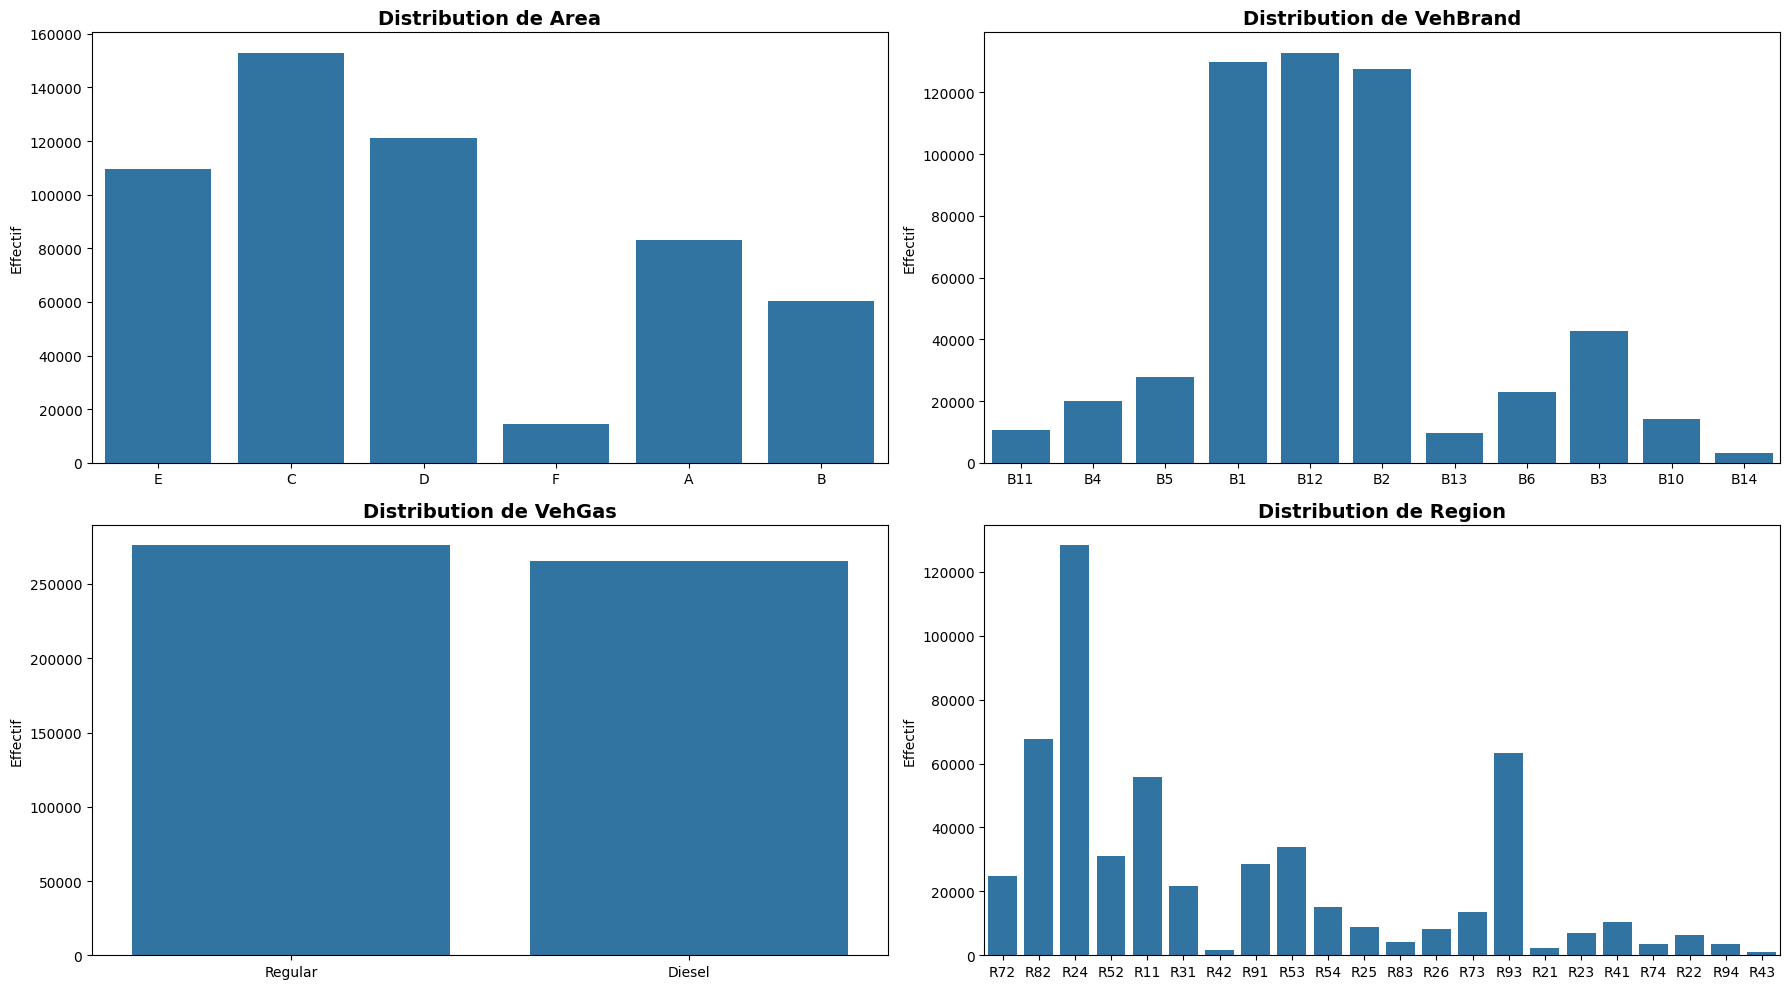

In [51]:
cat_cols = df_train_freq.select_dtypes(include='object').columns
n_cols_total = len(cat_cols)
n_cols_grid = 2
n_rows_grid = math.ceil(n_cols_total / n_cols_grid)
plt.figure(figsize=(18, n_rows_grid * 5))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

for i, col in enumerate(cat_cols):
    ax = plt.subplot(n_rows_grid, n_cols_grid, i + 1)
    order = df_train_freq[col].value_counts().index
    sns.countplot(data=df_train_freq, x=col)
    ax.set_title(f"Distribution de {col}", fontsize=14, fontweight='bold')
    ax.set_xlabel("")
    ax.set_ylabel("Effectif")

plt.tight_layout()
plt.show()

Effectuons désormais la détection d'outliers par méthode IQR

In [52]:
num_cols = df_train_freq.select_dtypes(include='number').columns

outliers_summary = {}

for col in num_cols:
    Q1 = df_train_freq[col].quantile(0.25)
    Q3 = df_train_freq[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_train_freq[(df_train_freq[col] < lower_bound) | (df_train_freq[col] > upper_bound)]
    outliers_summary[col] = len(outliers)

pd.DataFrame.from_dict(outliers_summary, orient='index', columns=['Nb Outliers']).sort_values(by='Nb Outliers', ascending=False)

,Nb Outliers
Density,62050
BonusMalus,49935
VehPower,27868
Frequency,27198
ClaimNb,27198
VehAge,2423
DrivAge,1017
IDpol,0
Exposure,0


Ces outliers sur ces catégories étaient prévisibles par la grande variance de ces variables, la méthode IQR n'est donc pas adapté à notre cas.

Analysons désormais la distributions de nos variables numériques pour détecter d'éventuelles outliers

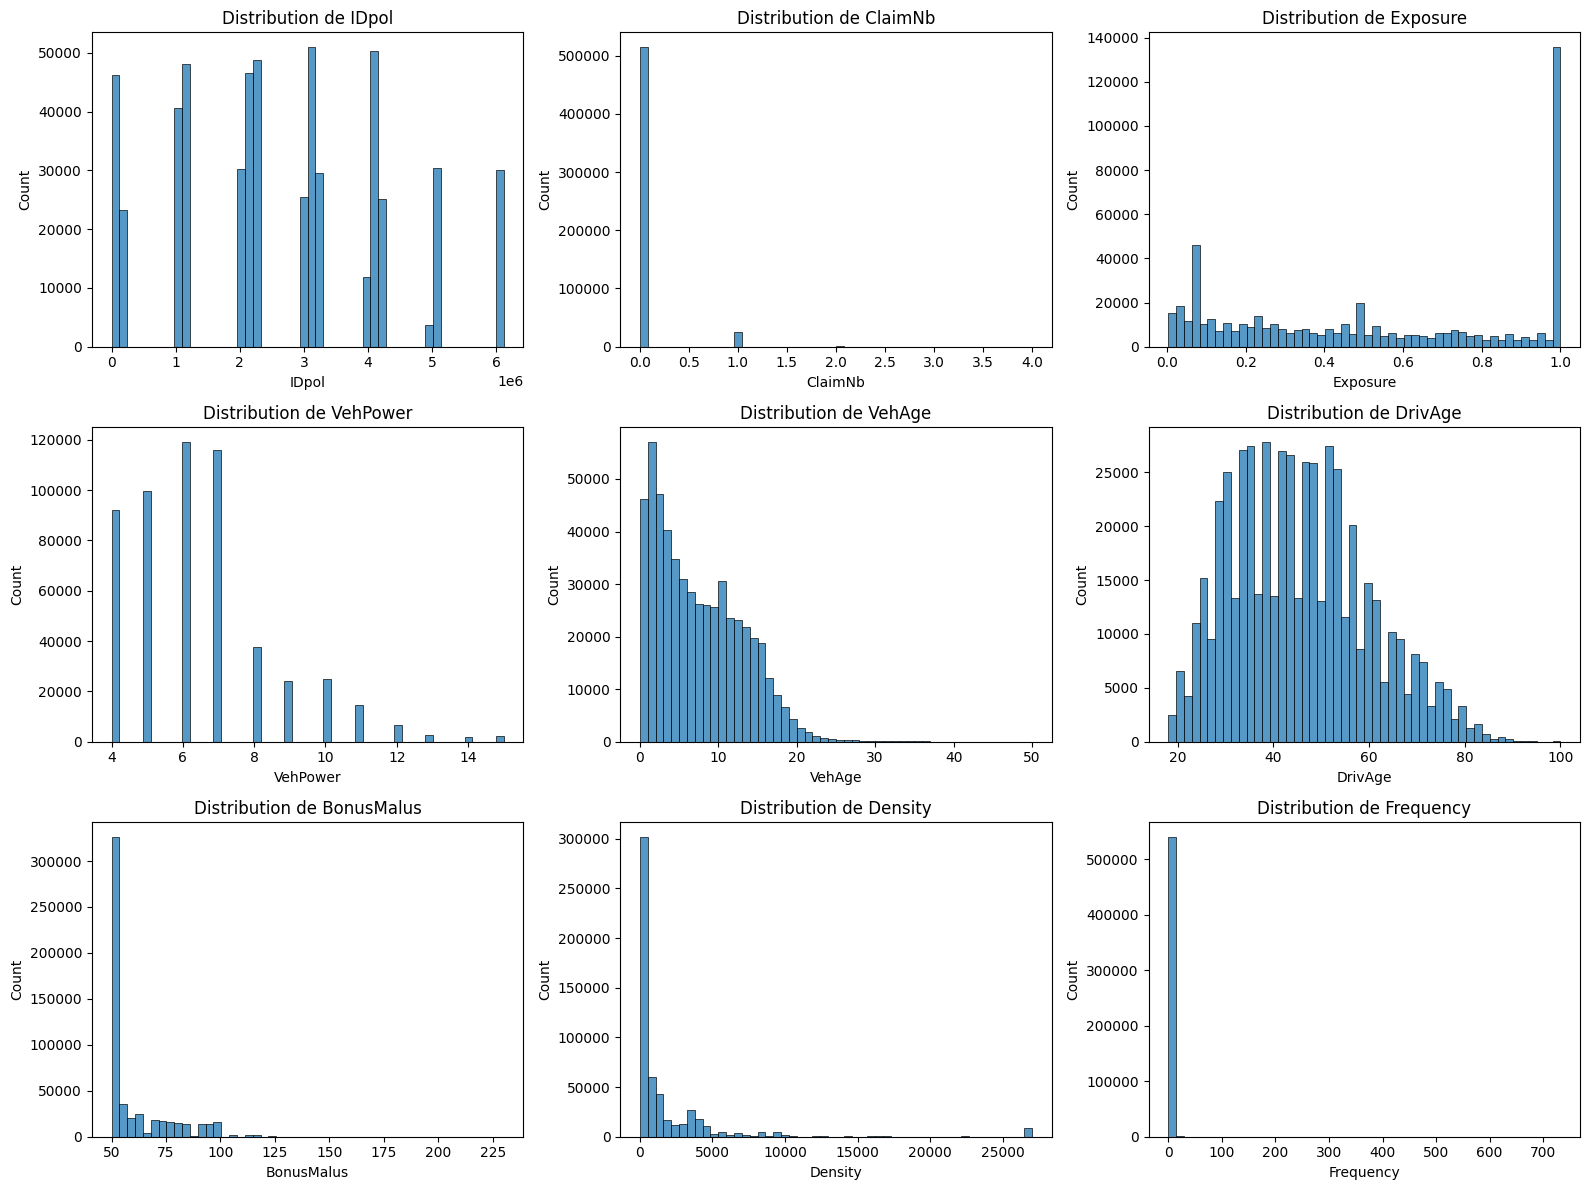

In [53]:
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.ravel()

for i, col in enumerate(num_cols):
    sns.histplot(df_train_freq[col], bins=50, ax=axes[i])
    axes[i].set_title(f'Distribution de {col}')

plt.tight_layout()
plt.show()

Représentation graphique des différents quartiles des variables explicatives.

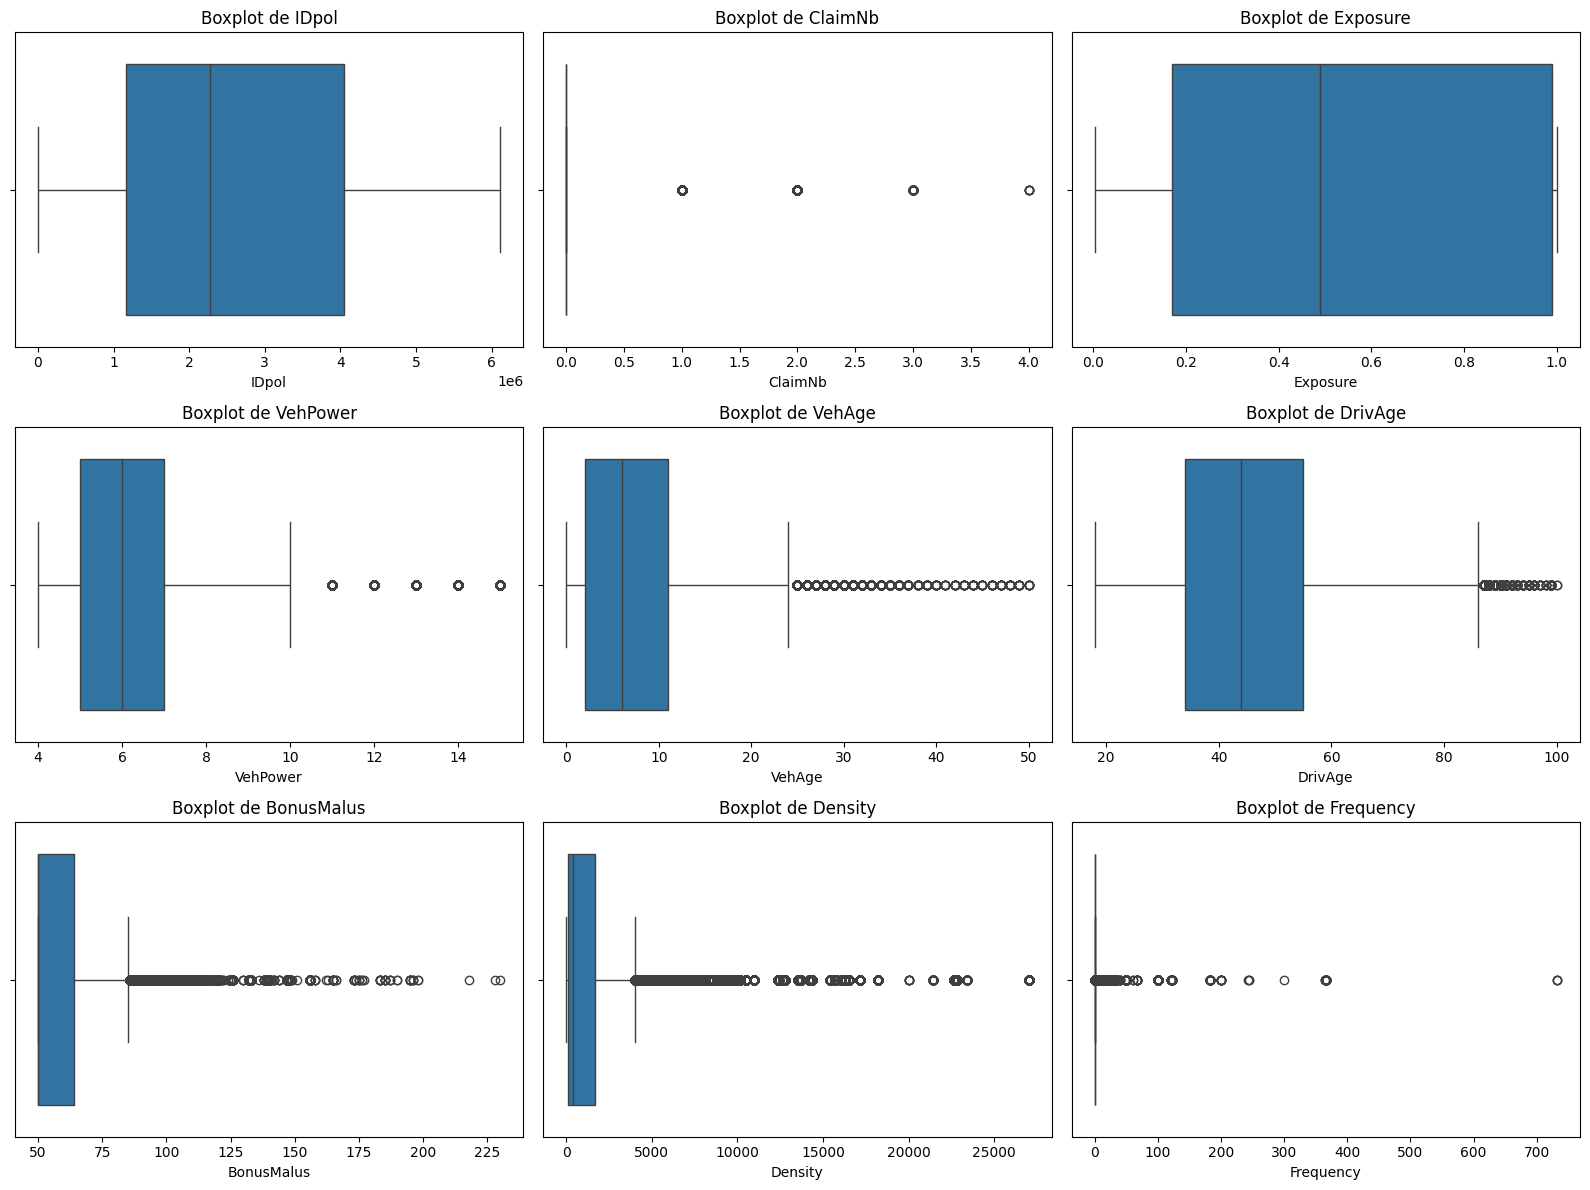

In [54]:
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.ravel()

for i, col in enumerate(num_cols):
    sns.boxplot(x=df_train_freq[col], ax=axes[i])
    axes[i].set_title(f'Boxplot de {col}')

plt.tight_layout()
plt.show()

Effectuons un test de surdispersion pour choisir le modèle le plus adapté pour l'estimation de la fréquence.

In [55]:
mean_claims = df_train_freq['ClaimNb'].mean()
var_claims = df_train_freq['ClaimNb'].var()
print(f"Ratio variance/moyenne : {var_claims/mean_claims:.3f}")

print(df_train_freq['ClaimNb'].value_counts().sort_index())
print(f"% avec 1 sinistre : {(df_train_freq['ClaimNb']==1).mean():.2%}")
print(f"% avec 2+ sinistres : {(df_train_freq['ClaimNb']>=2).mean():.2%}")

Ratio variance/moyenne : 1.061
ClaimNb
0    514148
1     25715
2      1413
3        65
4         5
Name: count, dtype: int64
% avec 1 sinistre : 4.75%
% avec 2+ sinistres : 0.27%


### 3.3 Analyse bivariée

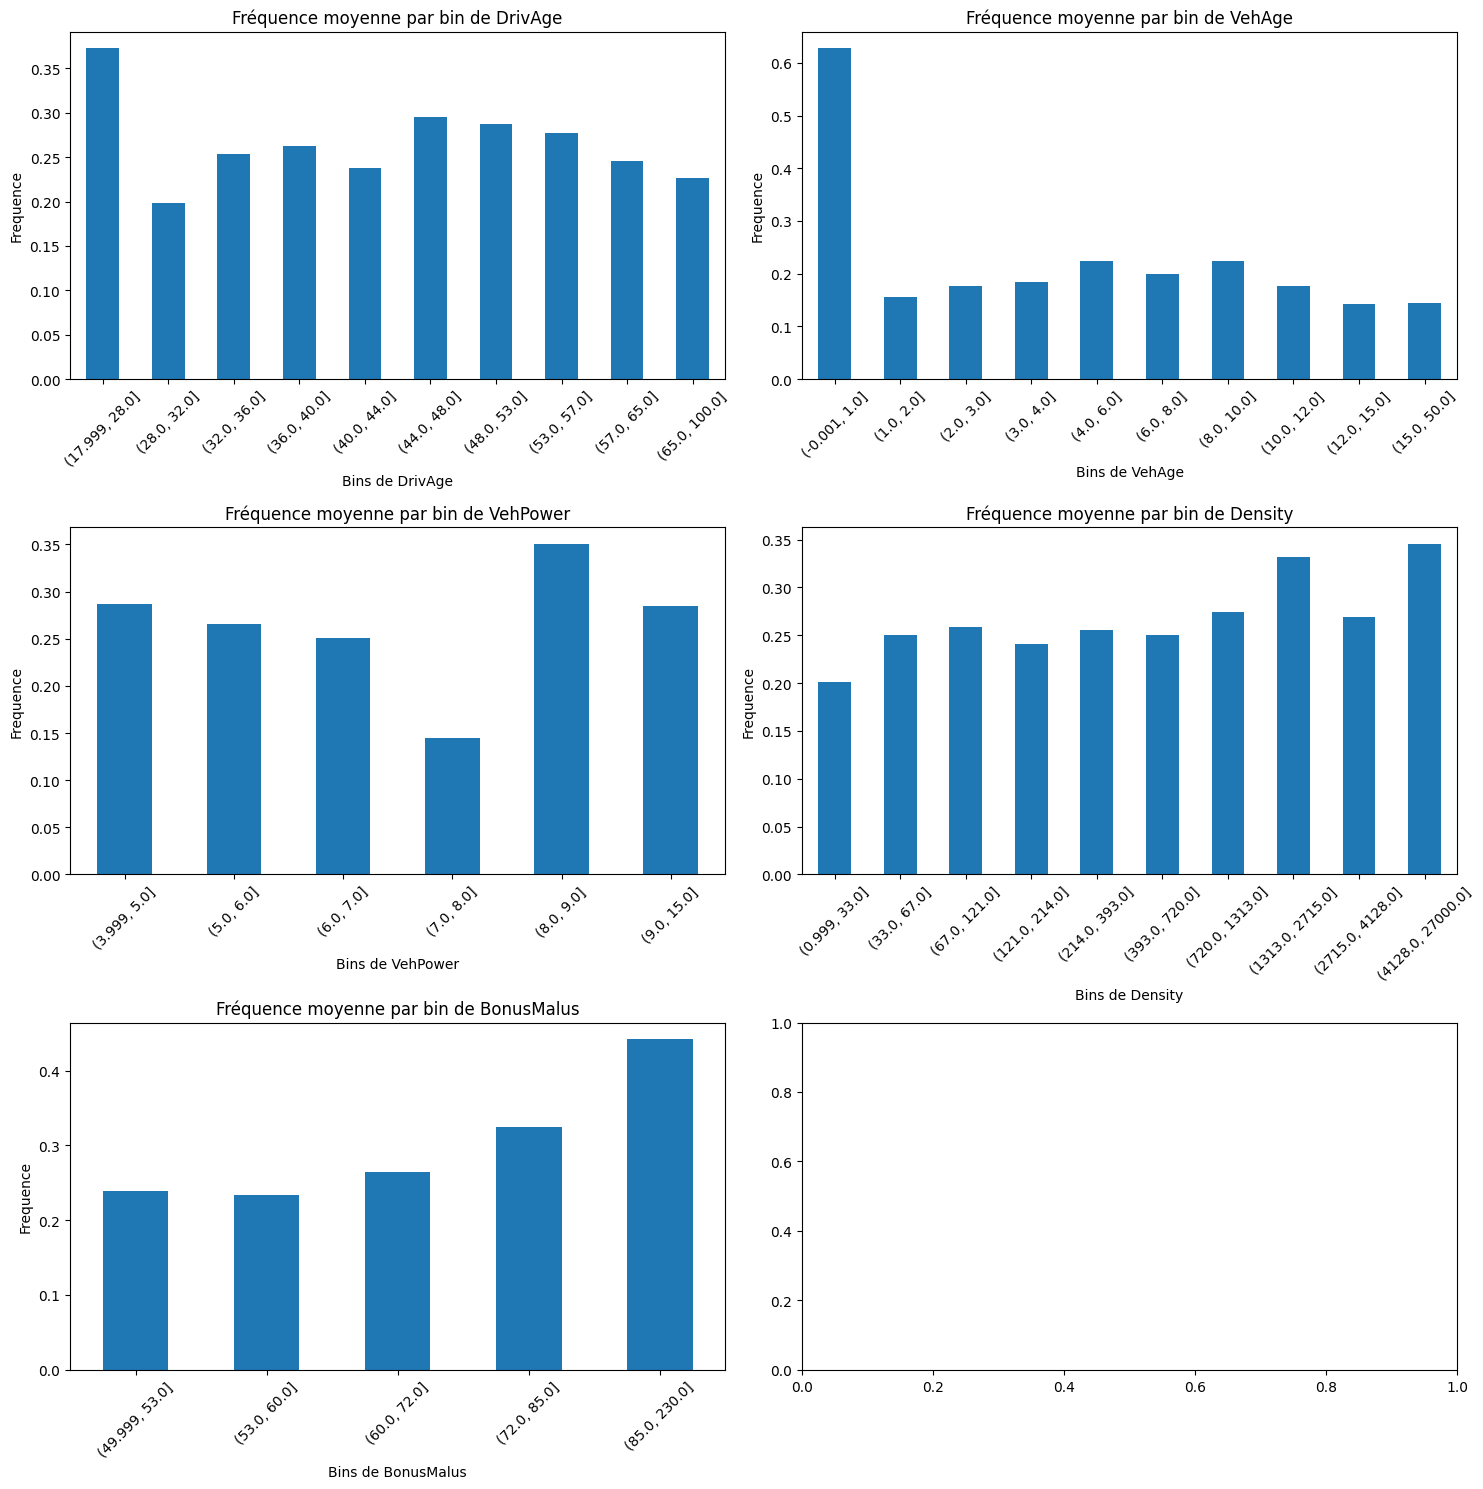

In [56]:
def bin_and_plot_multiple(df, cols, bins=10, cols_per_row=2):
    num_plots = len(cols)
    num_rows = math.ceil(num_plots / cols_per_row)
    fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(15, num_rows * 5))
    axes = axes.flatten() 
    for i, col in enumerate(cols):
        temp_df = df[[col, 'Frequency']].copy()
        temp_df['bin'] = pd.qcut(temp_df[col], q=bins, duplicates='drop')
        grouped = temp_df.groupby('bin', observed=False)['Frequency'].mean()
        grouped.plot(kind='bar', ax=axes[i])       
        axes[i].set_title(f"Fréquence moyenne par bin de {col}")
        axes[i].set_ylabel("Frequence")
        axes[i].set_xlabel(f"Bins de {col}")
        axes[i].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

variables = ['DrivAge', 'VehAge', 'VehPower', 'Density', 'BonusMalus']
bin_and_plot_multiple(df_train_freq, variables, bins=10, cols_per_row=2)

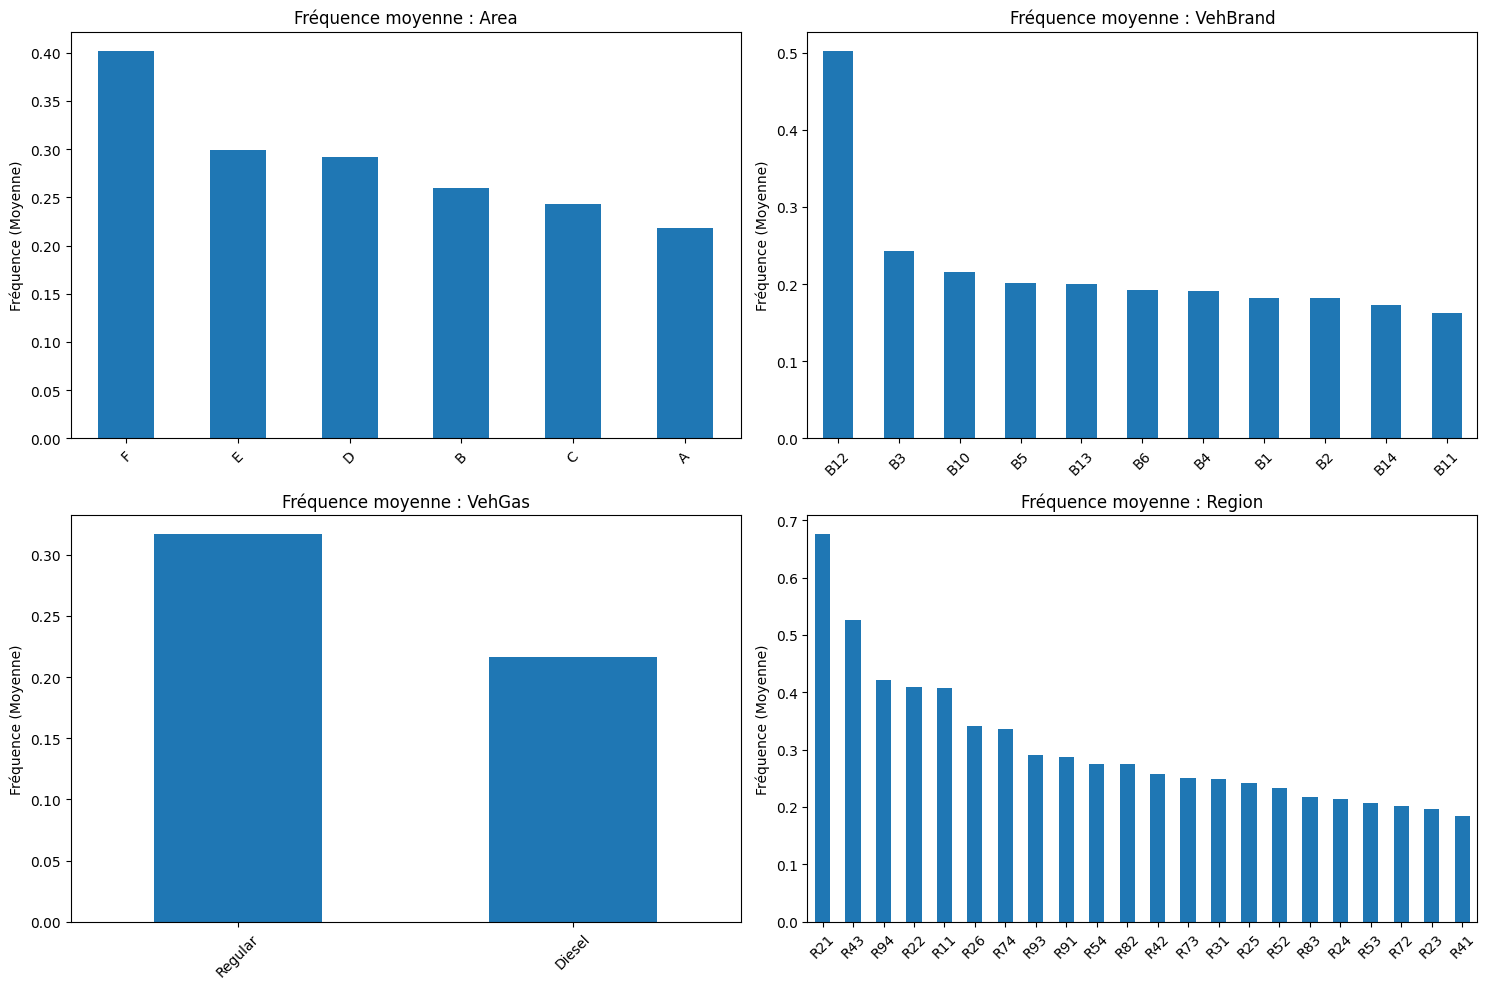

In [57]:
def plot_cat_vars_grid(df, cols, cols_per_row=2):
    num_plots = len(cols)
    num_rows = math.ceil(num_plots / cols_per_row)
    fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(15, num_rows * 5))
    axes = axes.flatten()
    for i, col in enumerate(cols):
        grouped = df.groupby(col, observed=False)['Frequency'].mean().sort_values(ascending=False)
        grouped.plot(kind='bar', ax=axes[i])      
        axes[i].set_title(f"Fréquence moyenne : {col}")
        axes[i].set_ylabel("Fréquence (Moyenne)")
        axes[i].set_xlabel("")
        axes[i].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()
plot_cat_vars_grid(df_train_freq, cat_cols, cols_per_row=2)

On voit clairement que la zone, la marque du vehicule, et la région ont un réel impact sur la fréquence, on va donc premièrement regarder matrice de corrélation sans encodage puis avec encodage.

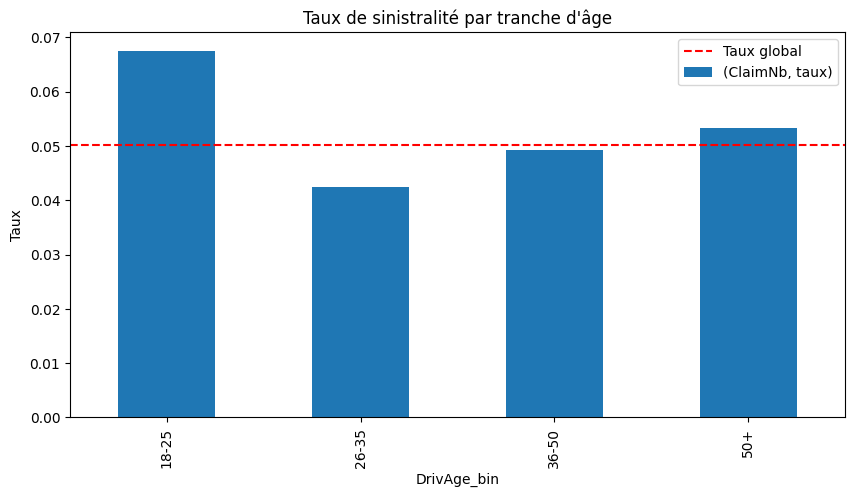

In [58]:
df_train_freq['DrivAge_bin'] = pd.cut(df_train_freq['DrivAge'], bins=[0,25,35,50,100],
                                  labels=['18-25', '26-35', '36-50', '50+'])
rate_by_age = df_train_freq.groupby('DrivAge_bin', observed=True).agg({
    'ClaimNb': [('taux', lambda x: (x>0).mean())]
})

rate_by_age.plot(kind='bar', figsize=(10, 5))
plt.title('Taux de sinistralité par tranche d\'âge')
plt.ylabel('Taux')
plt.axhline((df_train_freq['ClaimNb']>0).mean(), color='red', linestyle='--', label='Taux global')
plt.legend()
plt.show()

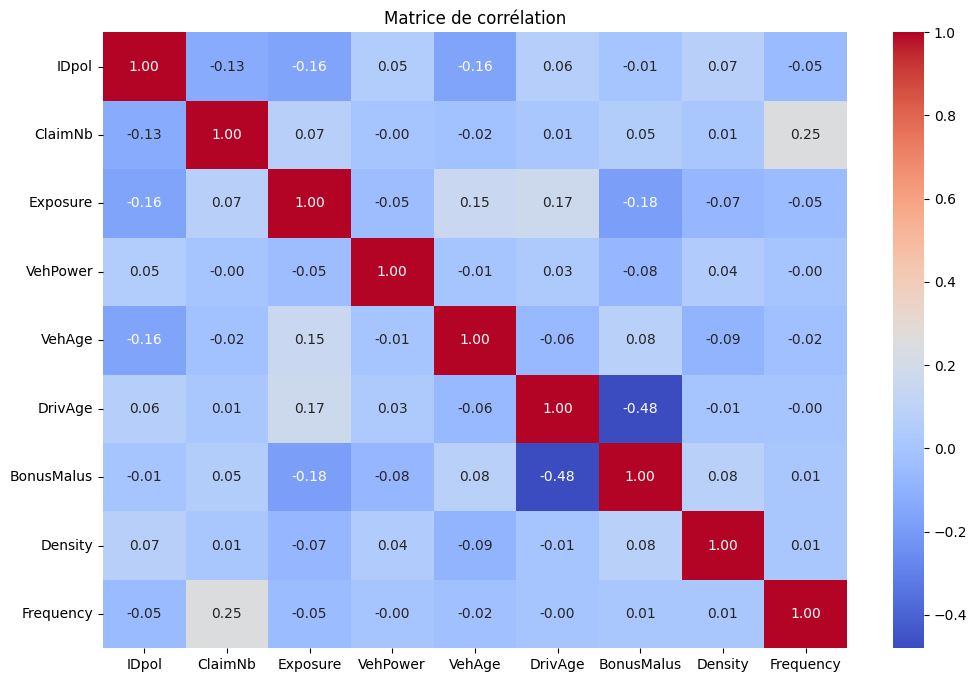

In [59]:
num_cols = df_train_freq.select_dtypes(include='number').columns
corr_matrix = df_train_freq[num_cols].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Matrice de corrélation")
plt.show()

## 4. EDA Sévérité

Commençons par créer le dataset qui nous servira pour notre EDA sur la sévérité.

In [60]:
df_train_sev = df_train[(df_train['ClaimNb'] > 0) & (df_train['ClaimAmount'] > 0)].copy()
print(f"Dimensions df_train_sev : {df_train_sev.shape}")

Dimensions df_train_sev : (19868, 15)


On supprime les ID retirés du dataset df_train_freq

### 4.1 Contrôle qualité des données

Vérification des premières lignes de notre dataset.

In [61]:
df_train_sev.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,Severity,Frequency
136501,1097726.0,2,0.24,D,6,9,30,76,B1,Diesel,575,R53,2256.24,1128.12,8.333333
244810,2094265.0,1,0.55,D,6,5,28,100,B2,Diesel,1313,R24,1172.00,1172.00,1.818182
82678,170979.0,1,1.00,B,4,10,39,70,B1,Regular,91,R24,1128.12,1128.12,1.000000
230594,2069702.0,1,0.85,C,7,15,28,90,B2,Regular,405,R24,660.84,660.84,1.176471
35394,72103.0,1,1.00,E,4,3,65,50,B2,Regular,4128,R52,376.22,376.22,1.000000


Analyse des statistiques descriptives

In [62]:
df_train_sev.describe()

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount,Severity,Frequency
count,1.986800e+04,19868.000000,19868.000000,19868.000000,19868.000000,19868.000000,19868.000000,19868.000000,1.986800e+04,1.986800e+04,19868.000000
mean,2.263837e+06,1.057026,0.689926,6.478558,7.381770,45.128297,65.035233,1988.892893,2.471130e+03,2.286745e+03,3.208427
std,1.582384e+06,0.243957,0.313296,2.021377,5.116026,14.709567,19.877699,4122.460627,3.368530e+04,3.228140e+04,9.919083
min,1.390000e+02,1.000000,0.002740,4.000000,0.000000,18.000000,50.000000,2.000000,1.000000e+00,1.000000e+00,1.000000
25%,1.081916e+06,1.000000,0.440000,5.000000,3.000000,34.000000,50.000000,111.000000,7.507800e+02,7.137600e+02,1.000000
50%,2.129048e+06,1.000000,0.760000,6.000000,7.000000,44.000000,55.000000,511.000000,1.172000e+03,1.172000e+03,1.351351
75%,3.178026e+06,1.000000,1.000000,7.000000,11.000000,54.000000,76.000000,2131.000000,1.324400e+03,1.217485e+03,2.439024
max,6.113971e+06,4.000000,1.000000,15.000000,39.000000,99.000000,228.000000,27000.000000,4.075401e+06,4.075401e+06,365.000004


Vérification présence valeurs manquantes.

In [63]:
df_train_sev.isnull().sum()

IDpol          0
ClaimNb        0
Exposure       0
Area           0
VehPower       0
VehAge         0
DrivAge        0
BonusMalus     0
VehBrand       0
VehGas         0
Density        0
Region         0
ClaimAmount    0
Severity       0
Frequency      0
dtype: int64

Il ne manque pas de valeurs, cherchons maintenant la présence de valeurs dupliquées

In [64]:
df_train_sev.duplicated().sum()

np.int64(0)

### 4.2 Analyse univariée

Analysons les statistiques descriptives du dataset.

In [65]:
cat_cols = df_train_sev.select_dtypes(include='object').columns
for col in cat_cols:
    print(f"\nColonne {col} :")
    print(df_train_freq[col].value_counts())


Colonne Area :
Area
C    152896
D    121140
E    109635
A     83131
B     60219
F     14325
Name: count, dtype: int64

Colonne VehBrand :
VehBrand
B12    132835
B1     129820
B2     127577
B3      42636
B5      27793
B6      22854
B4      19992
B10     14132
B11     10751
B13      9738
B14      3218
Name: count, dtype: int64

Colonne VehGas :
VehGas
Regular    276025
Diesel     265321
Name: count, dtype: int64

Colonne Region :
Region
R24    128302
R82     67697
R93     63177
R11     55853
R53     33734
R52     31112
R91     28449
R72     24937
R31     21761
R54     15233
R73     13627
R41     10390
R25      8740
R26      8314
R23      7023
R22      6390
R83      4172
R74      3630
R94      3576
R21      2402
R42      1775
R43      1052
Name: count, dtype: int64


Calculons la sévérité moyenne globale, cette information nous sera utile lors de l'entraînement de nos modèles.

In [66]:
avg_severity = df_train_sev["ClaimAmount"].sum() / df_train_sev["ClaimAmount"].count()

print(f"Sévérité moyenne globale : {avg_severity:.2f} €")

Sévérité moyenne globale : 2471.13 €


Effectuons désormais des histplots de nos variables numériques pour observer leurs distributions.

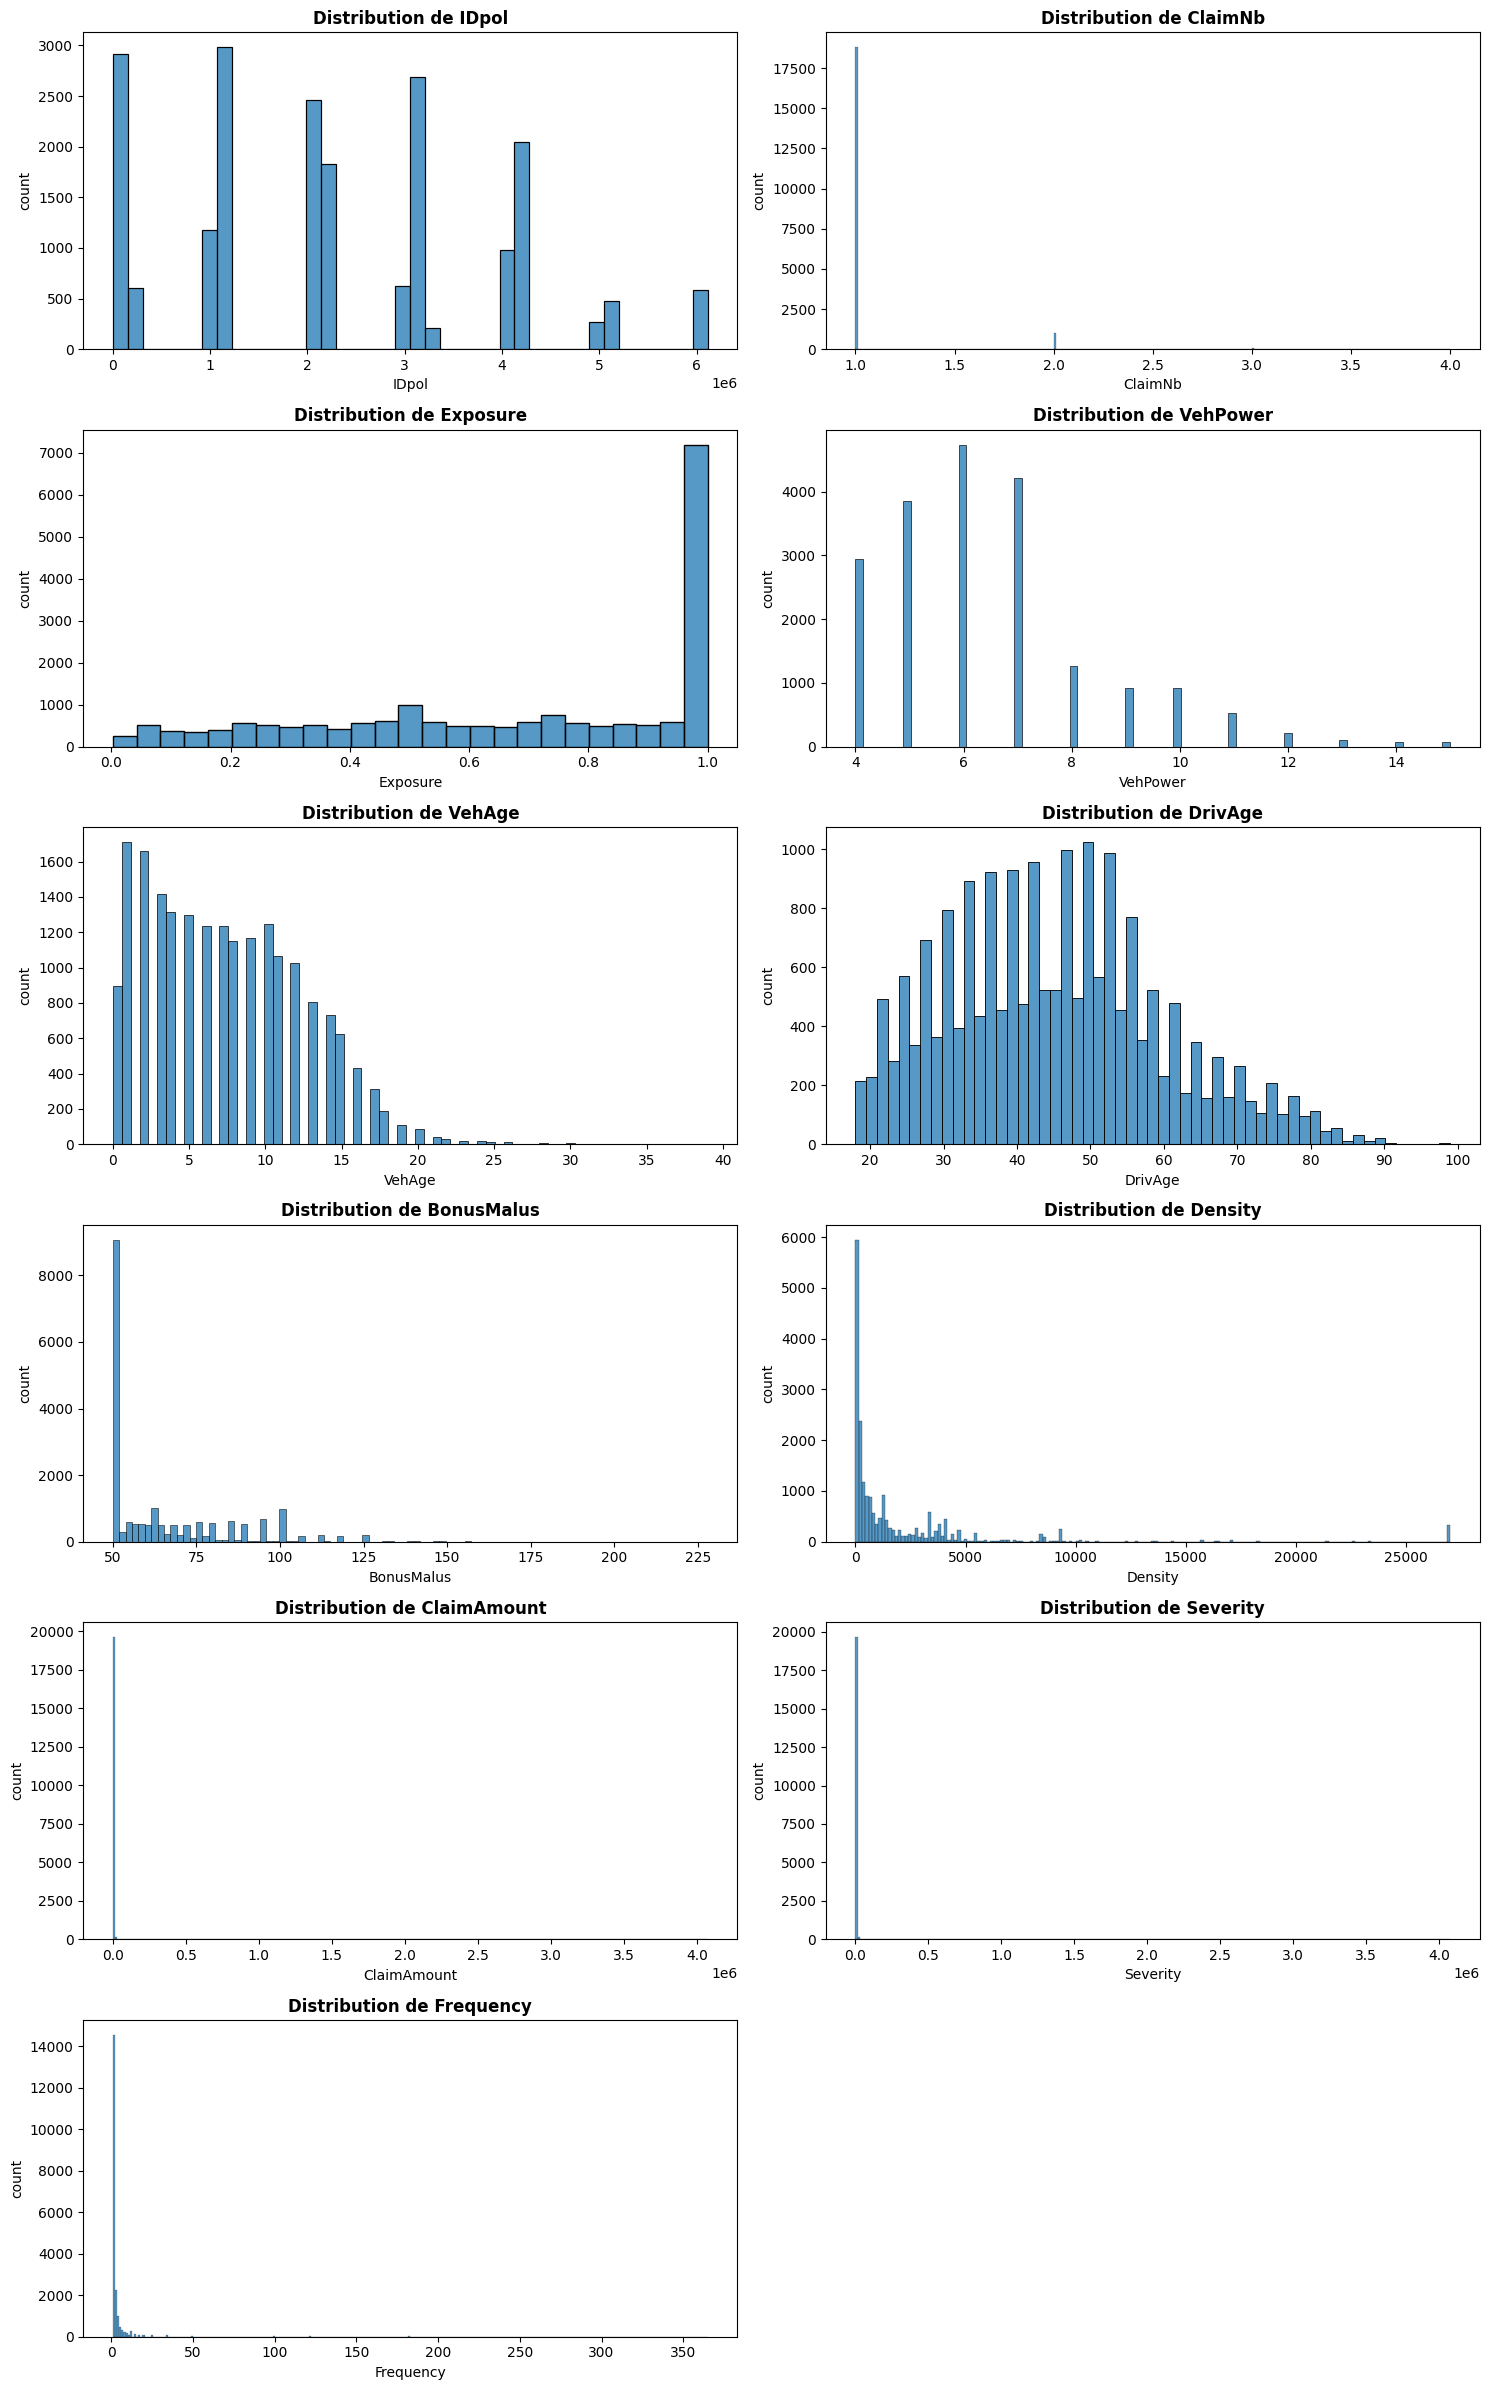

In [67]:
num_cols_sev = df_train_sev.select_dtypes(include='number').columns
n_cols = 2  
n_rows = math.ceil(len(num_cols_sev) / n_cols)  

plt.figure(figsize=(15, n_rows * 4))

for i, col in enumerate(num_cols_sev):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df_train_sev[col])
    plt.title(f'Distribution de {col}', fontsize=12, fontweight='bold')
    plt.xlabel(col)
    plt.ylabel('count')

plt.tight_layout()
plt.show()

On constate que la répartition de nos données est biaisée par la grande quantitée de 0 sur de nombreuses variables, il est préférable de les passer au logarithme pour obtenir un meilleur aperçu de leur distribution.

Ce choix de représentatin graphique pour les réclamations ne semble pas le plus idéal, passons la distribution au log pour en obtenir un meilleur aperçu.

Text(0.5, 1.0, 'Distribution log(1 + ClaimAmount)')

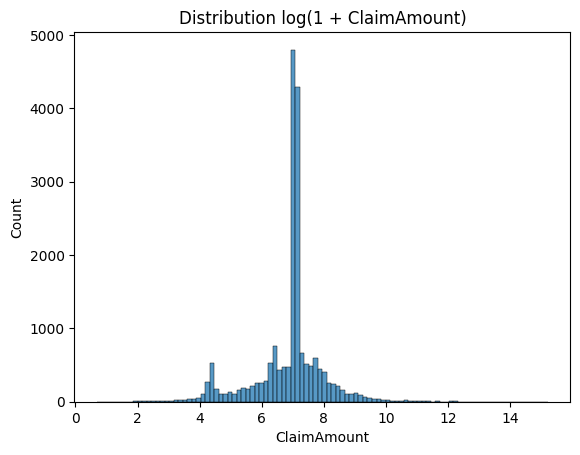

In [68]:
sns.histplot(np.log1p(df_train_sev['ClaimAmount']), bins=100)
plt.title("Distribution log(1 + ClaimAmount)")

Notre représentation graphique est largement plus visible, on voit donc que la majorité des réclamations se situent autour de 7, sur une échelle passée au log, regardons désormais la moyenne,la médiane et les valeurs par quantile de la feature.

In [69]:
print("Sévérité moyenne :", df_train_sev["ClaimAmount"].mean())
print("Sévérité médiane :", df_train_sev["ClaimAmount"].median())
print("Quantiles :", df_train_sev["ClaimAmount"].quantile([0.5, 0.75, 0.9, 0.95, 0.99]))

Sévérité moyenne : 2471.1304600362396
Sévérité médiane : 1172.0
Quantiles : 0.50     1172.0000
0.75     1324.4000
0.90     2966.3440
0.95     5000.0000
0.99    17399.3896
Name: ClaimAmount, dtype: float64


### 4.3 Analyse bivariée

Etudions les relations entre les différentes variables explcatives et notre variable cible (`Severity`)

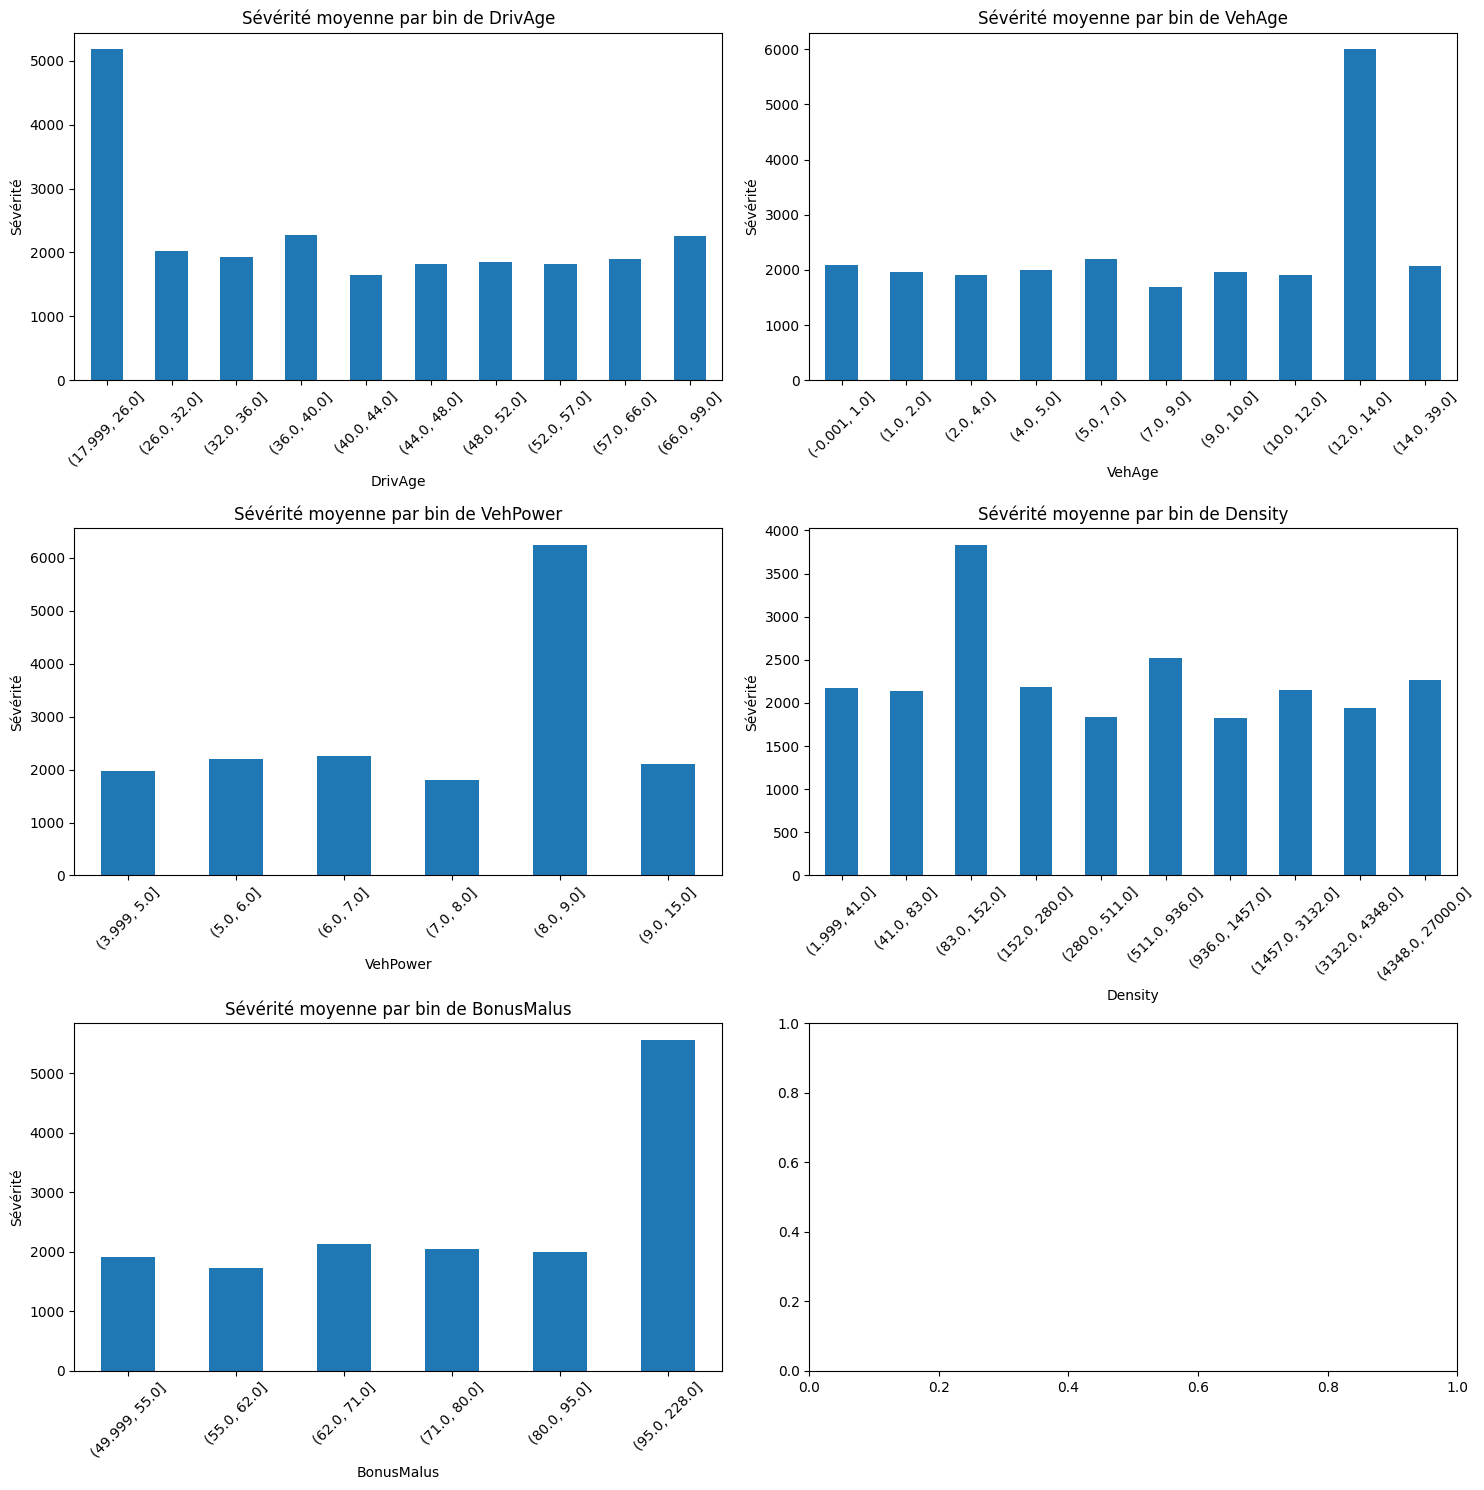

In [70]:
def bin_and_plot_grid(df, cols, bins=10, n_cols=2):
    n_rows = math.ceil(len(cols) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
    axes = axes.flatten()
    for i, col in enumerate(cols):
        temp_df = df[[col, 'Severity']].copy()
        temp_df['bin'] = pd.qcut(temp_df[col], q=bins, duplicates='drop')
        grouped = temp_df.groupby('bin', observed=False)['Severity'].mean()
        grouped.plot(kind='bar', ax=axes[i])        
        axes[i].set_title(f"Sévérité moyenne par bin de {col}")
        axes[i].set_ylabel("Sévérité")
        axes[i].set_xlabel(col)
        axes[i].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

variables = ['DrivAge', 'VehAge', 'VehPower', 'Density', 'BonusMalus']
bin_and_plot_grid(df_train_sev, variables, bins=10, n_cols=2)

On observe que pour chaque variables numériques, il y a bien un lien avec la sévérité du sinistre, en particulier pour DrivAge et VehPower. Passons désormais aux variables catégorielles:

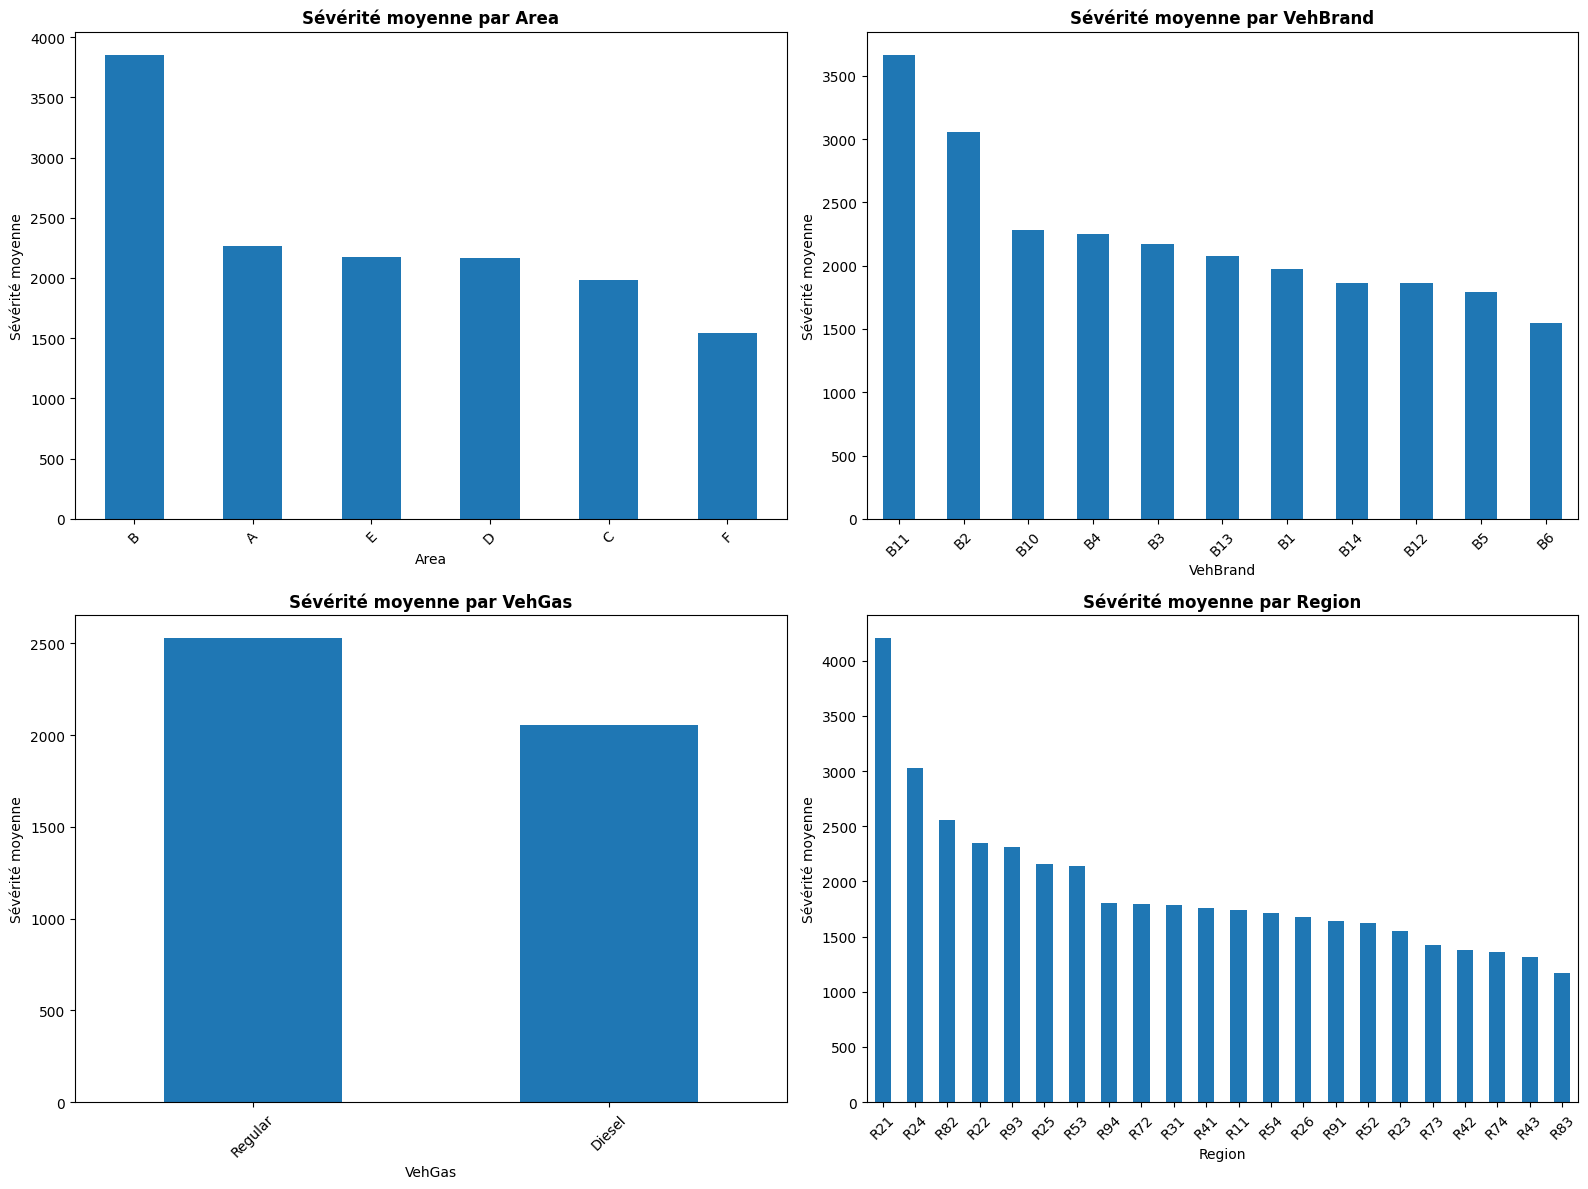

In [71]:
def plot_cat_sev_grid(df, cols, n_cols=2):
    n_rows = math.ceil(len(cols) / n_cols)   
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 6))
    axes = axes.flatten()
    for i, col in enumerate(cols):
        grouped = df.groupby(col, observed=False)['Severity'].mean().sort_values(ascending=False)
        grouped.plot(kind='bar', ax=axes[i])
        axes[i].set_title(f"Sévérité moyenne par {col}", fontsize=12, fontweight='bold')
        axes[i].set_ylabel("Sévérité moyenne")
        axes[i].set_xlabel(col)
        axes[i].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()
    
cat_cols = df_train_sev.select_dtypes(include=['object', 'category']).columns
plot_cat_sev_grid(df_train_sev, cat_cols, n_cols=2)

Encore une fois, il existe un lien entre nos features catégorielles et la sévérité, cependant, il est moins marqué qu'avec certaines de nos variables numériques. Nous allons désormais effectuer une matrice de corrélation.

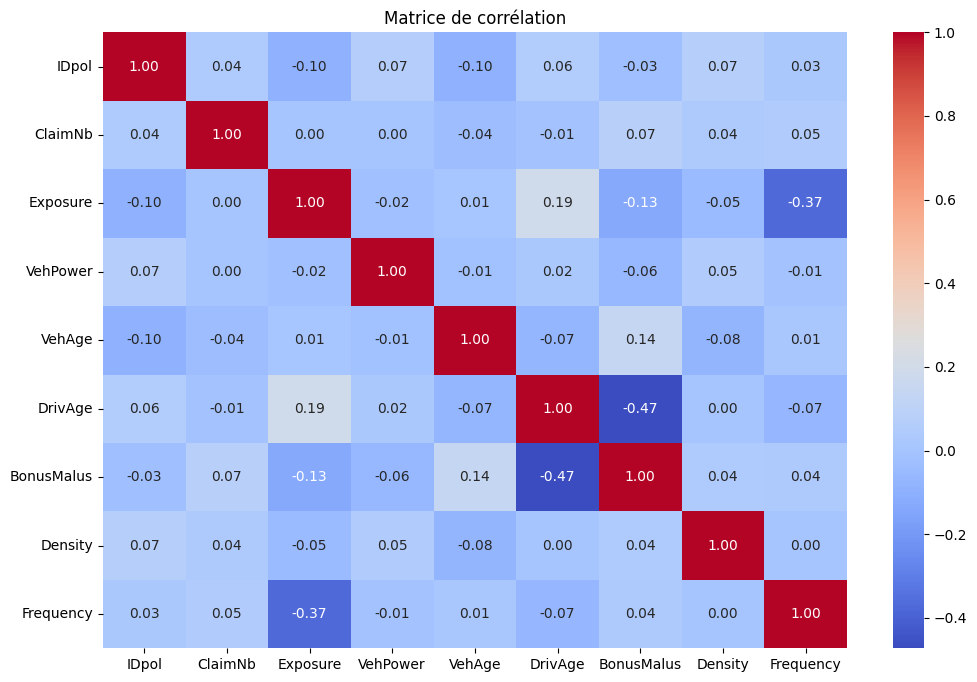

In [72]:
corr_matrix = df_train_sev[num_cols].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Matrice de corrélation")
plt.show()


Il ne semble pas exister de lien évident entre ClaimAmount et les autres features et ce résultat 

## 5. Analyse comparative Fréquence vs Sévérité

Réalisons une matrice de corrélation entre (`ClaimNb`) et  (`Severity`) pou vérifier si ils sont décorrélés

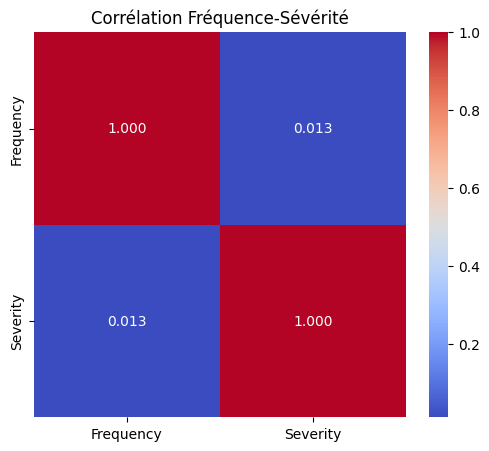

In [73]:
corr_matrix = df_train[['Frequency', 'Severity']].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, fmt=".3f", cmap='coolwarm')
plt.title("Corrélation Fréquence-Sévérité")
plt.show()

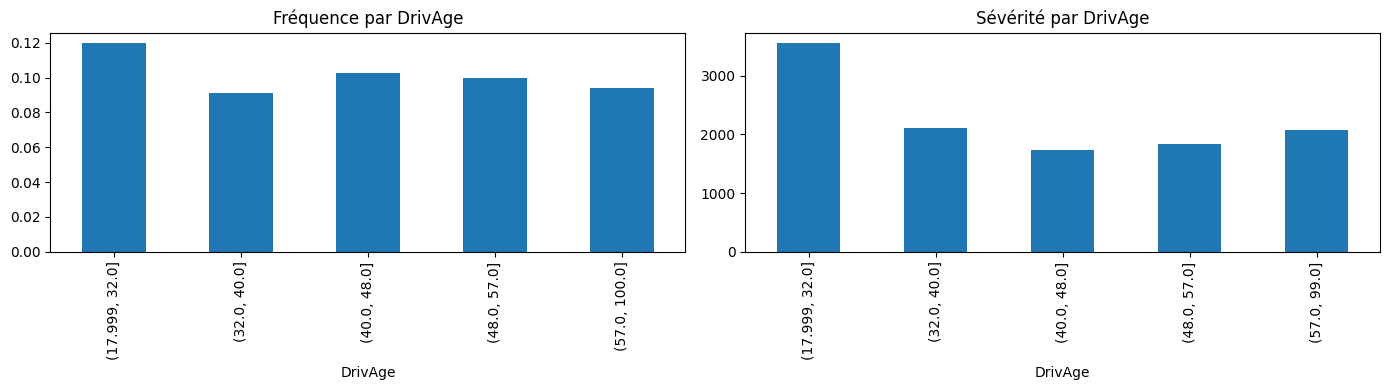

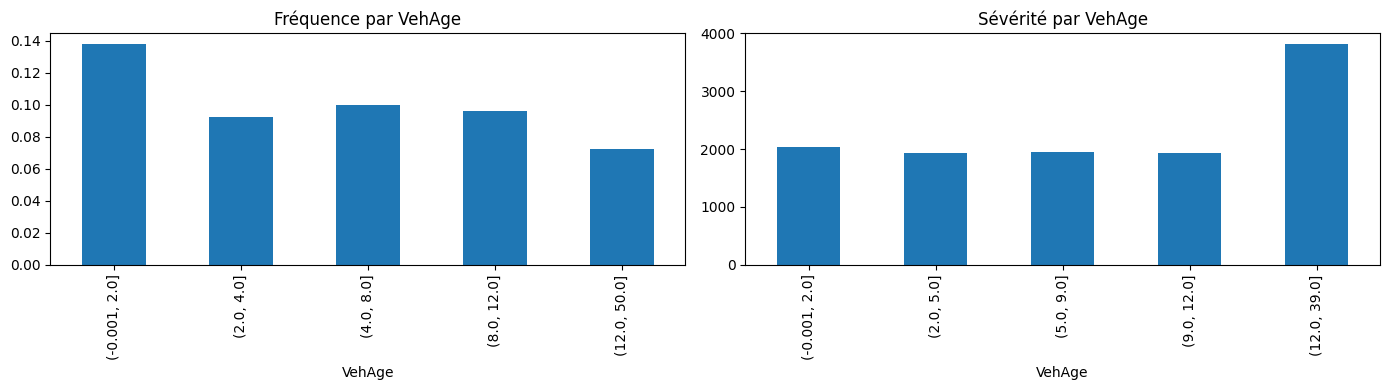

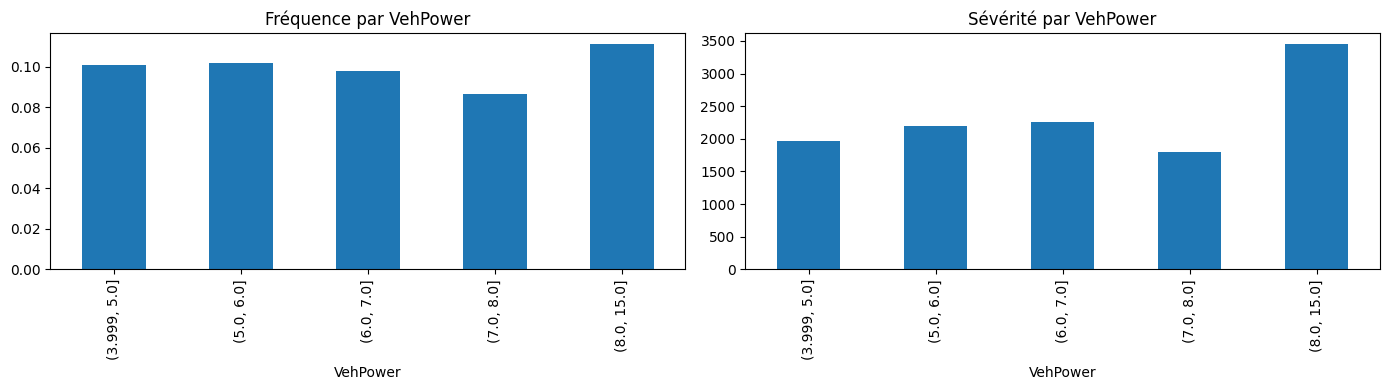

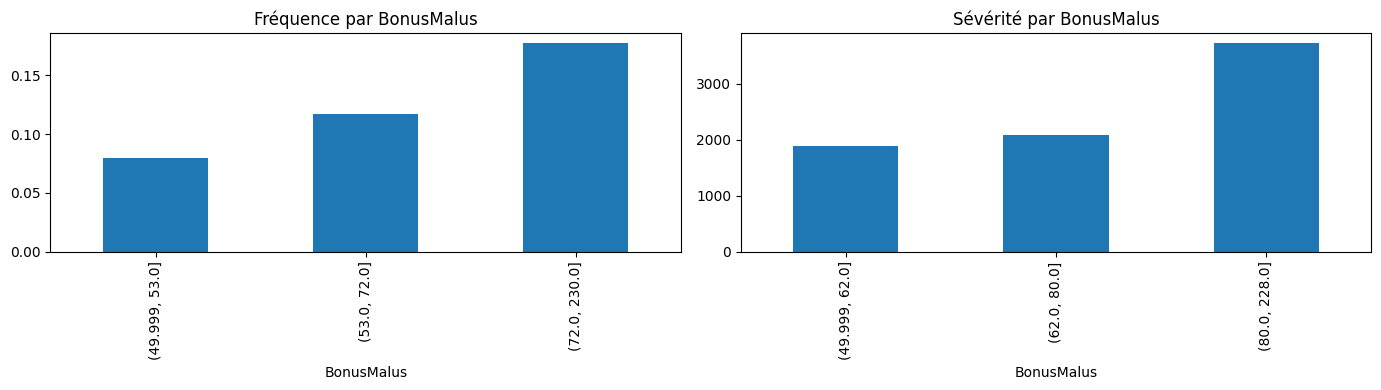

In [74]:
for var in ['DrivAge', 'VehAge', 'VehPower', 'BonusMalus']:
    bins = pd.qcut(df_train_freq[var], q=5, duplicates='drop')
    
    freq_by_bin = df_train_freq.groupby(bins).apply(
        lambda x: x['ClaimNb'].sum() / x['Exposure'].sum()
    )
    
    sev_data = df_train_sev[df_train_sev['Severity'] > 0]
    sev_by_bin = sev_data.groupby(pd.qcut(sev_data[var], q=5, duplicates='drop'))['Severity'].mean()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
    freq_by_bin.plot(kind='bar', ax=ax1, title=f'Fréquence par {var}')
    sev_by_bin.plot(kind='bar', ax=ax2, title=f'Sévérité par {var}')
    plt.tight_layout()
    plt.show()

                        Nb_contrats  Frequence  Ratio_vs_Moy
Segment                                                     
Jeune + Puissant                375   0.240186      2.384980
Jeune + Normal                23915   0.188429      1.871040
Expérimenté + Puissant        27493   0.099182      0.984848
Standard                     489563   0.097398      0.967134


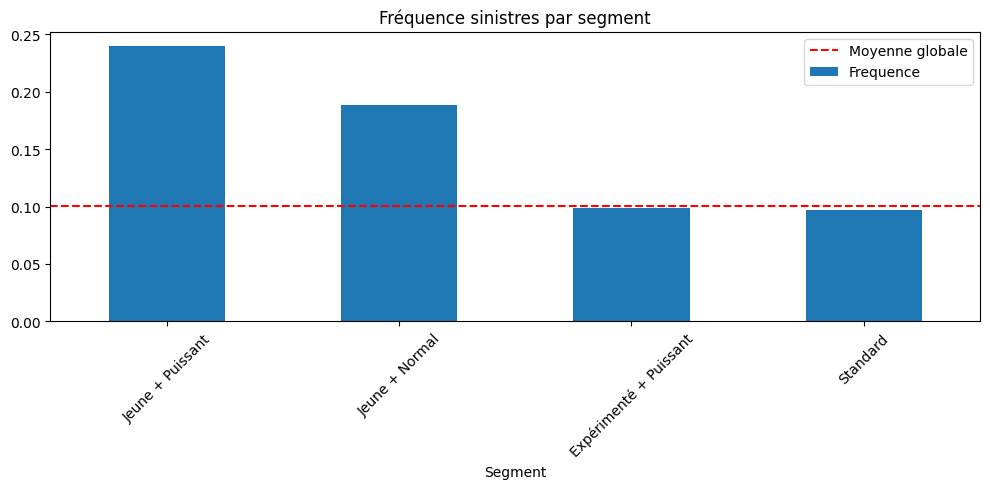

In [75]:
conditions = [
    (df_train_freq['DrivAge'] < 25) & (df_train_freq['VehPower'] > 10),
    (df_train_freq['DrivAge'] < 25),
    (df_train_freq['VehPower'] > 10)
]
choix = ['Jeune + Puissant', 'Jeune + Normal', 'Expérimenté + Puissant']
df_train_freq['Segment'] = np.select(conditions, choix, default='Standard')

freq_globale = df_train_freq['ClaimNb'].sum() / df_train_freq['Exposure'].sum()

analysis = df_train_freq.groupby('Segment').agg({
    'IDpol': 'count',
    'ClaimNb': 'sum',
    'Exposure': 'sum'
}).rename(columns={'IDpol': 'Nb_contrats'})

analysis['Frequence'] = analysis['ClaimNb'] / analysis['Exposure']
analysis['Ratio_vs_Moy'] = analysis['Frequence'] / freq_globale

analysis = analysis.sort_values('Frequence', ascending=False)
print(analysis[['Nb_contrats', 'Frequence', 'Ratio_vs_Moy']])

analysis['Frequence'].plot(kind='bar', figsize=(10, 5), title='Fréquence sinistres par segment', rot=45)
plt.axhline(freq_globale, color='r', linestyle='--', label='Moyenne globale')
plt.legend()
plt.tight_layout()
plt.show()

 DENSITY PAR AREA:
              mean   median          std
Area                                    
F     22005.502688  27000.0  6382.750371
E      4383.112336   3744.0  1954.709174
D      1075.461235   1054.0   398.569142
C       248.699966    222.0   113.775506
B        72.585629     72.0    14.834807
A        27.503567     27.0    12.475211


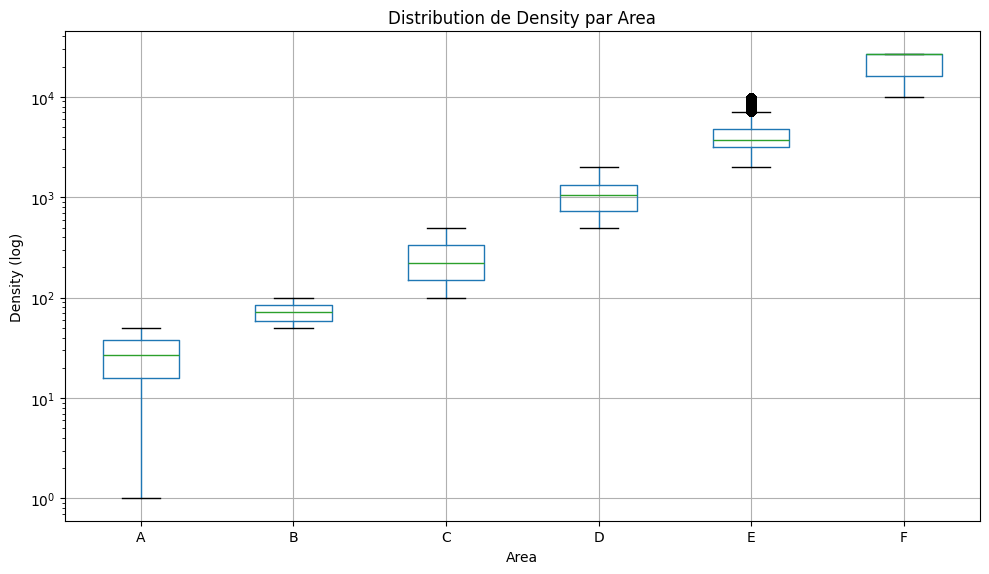

In [76]:
area_density = df_train_freq.groupby('Area')['Density'].agg(['mean', 'median', 'std'])
print(" DENSITY PAR AREA:")
print(area_density.sort_values('mean', ascending=False))

fig, ax = plt.subplots(figsize=(10, 6))
df_train_freq.boxplot(column='Density', by='Area', ax=ax)
ax.set_title('Distribution de Density par Area')
ax.set_xlabel('Area')
ax.set_ylabel('Density (log)')
ax.set_yscale('log')
plt.suptitle('') 
plt.tight_layout()
plt.show()

On voit ici très clairement que Area est un découpage de Density en 6 catégories, comme Density possède plus d'informations, nous supprimerons donc la variable (`Area`).

## 6. Preprocessing

In [77]:
bins = [17, 21, 25, 35, 55, 70, 110]
labels = ['18-21', '22-25', '26-35', '36-55', '56-70', '70+']

df_train['DrivAge_Bin'] = pd.cut(df_train['DrivAge'], bins=bins, labels=labels)
df_test['DrivAge_Bin'] = pd.cut(df_test['DrivAge'], bins=bins, labels=labels)

df_train = df_train.drop(columns=['DrivAge'], errors='ignore')
df_test = df_test.drop(columns=['DrivAge'], errors='ignore')

In [78]:
seuil_capping = df_train.loc[df_train['ClaimAmount'] > 0, 'ClaimAmount'].quantile(0.99)

y_train_capped = df_train['ClaimAmount'].clip(upper=seuil_capping)
y_test_capped = df_test['ClaimAmount'].clip(upper=seuil_capping)

total_reel = df_train['ClaimAmount'].sum()
total_capped = y_train_capped.sum()
perte_ecrêtement = total_reel - total_capped

chargement_moyen = perte_ecrêtement / len(df_train)

print(f"Montant total écrêté : {perte_ecrêtement:,.0f}€")
print(f"Surcharge à ajouter au tarif final : +{chargement_moyen:.2f}€ par contrat")

Montant total écrêté : 16,271,500€
Surcharge à ajouter au tarif final : +30.06€ par contrat


In [79]:
X_train_freq = df_train.drop(columns=['IDpol', 'ClaimNb', 'ClaimAmount', 'Severity', 'Exposure', 'Frequency', 'Area'])
y_train_freq = df_train['ClaimNb']
expo_train = df_train['Exposure'].values

X_test_freq = df_test.drop(columns=['IDpol', 'ClaimNb', 'ClaimAmount', 'Severity', 'Frequency', 'Exposure', 'Area'])
y_test_freq = df_test['ClaimNb']
expo_test = df_test['Exposure'].values

print(f" X_train: {X_train_freq.shape}")
print(f" X_test:  {X_test_freq.shape}")
print(f" y_train: {y_train_freq.shape}")
print(f" y_test:  {y_test_freq.shape}")

 X_train: (541346, 8)
 X_test:  (135337, 8)
 y_train: (541346,)
 y_test:  (135337,)


In [80]:
train_sev_mask = (df_train['ClaimNb'] > 0) & (df_train['Severity'] > 0)
test_sev_mask = (df_test['ClaimNb'] > 0) & (df_test['Severity'] > 0)

X_train_sev = df_train[train_sev_mask].drop(columns=['IDpol', 'ClaimNb', 'ClaimAmount', 'Exposure', 'Area', 'Severity']).reset_index(drop=True)
X_test_sev = df_test[test_sev_mask].drop(columns=['IDpol', 'ClaimNb', 'ClaimAmount', 'Severity', 'Area', 'Exposure']).reset_index(drop=True)

y_train_sev = y_train_capped[train_sev_mask].reset_index(drop=True)
y_test_sev = y_test_capped[test_sev_mask].reset_index(drop=True)

weights_train_sev = df_train.loc[train_sev_mask, 'ClaimNb'].values
weights_test_sev = df_test.loc[test_sev_mask, 'ClaimNb'].values

print(f" X_train_sev: {X_train_sev.shape}")
print(f" X_test_sev: {X_test_sev.shape}")
print(f" y_train_sev: {y_train_sev.shape}")
print(f" y_test_sev: {y_test_sev.shape}")

 X_train_sev: (19868, 9)
 X_test_sev: (5014, 9)
 y_train_sev: (19868,)
 y_test_sev: (5014,)


In [81]:
X_train_freq.info()
X_train_sev.info()

<class 'pandas.core.frame.DataFrame'>
Index: 541346 entries, 541204 to 355610
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   VehPower     541346 non-null  int64   
 1   VehAge       541346 non-null  int64   
 2   BonusMalus   541346 non-null  int64   
 3   VehBrand     541346 non-null  object  
 4   VehGas       541346 non-null  object  
 5   Density      541346 non-null  int64   
 6   Region       541346 non-null  object  
 7   DrivAge_Bin  541346 non-null  category
dtypes: category(1), int64(4), object(3)
memory usage: 33.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19868 entries, 0 to 19867
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   VehPower     19868 non-null  int64   
 1   VehAge       19868 non-null  int64   
 2   BonusMalus   19868 non-null  int64   
 3   VehBrand     19868 non-null  object  
 4   VehGas       19

A travers l'EDA, on a observé la présence de contrats avec des fréquences de sinistres aberrantes, supprimons-les

Par ailleurs, les montants de sinistres suivent typiquement une distribution log-normale ou gamma, pas une distribution normale. La transformation log permet de se rapprocher d'une distribution normale.

### Encodage

Pour préparer les variables catégorielles ne présentant aucun ordre entre leurs modalités, nous allons utiliser le one-hot encoder

In [82]:
for col in ['VehBrand', 'Region']:
    counts = X_train_sev[col].value_counts()
    rare_categories = counts[counts < 5].index
    X_train_sev[col] = X_train_sev[col].replace(rare_categories, 'Other')
    X_test_sev[col] = X_test_sev[col].replace(rare_categories, 'Other')

In [83]:
density_transformer = Pipeline(steps=[
    ('log', FunctionTransformer(np.log1p, validate=False)),
    ('scaler', StandardScaler())
])

preprocessor_sev = ColumnTransformer(
    transformers=[
        ('dens', density_transformer, ['Density']),
        ('num', StandardScaler(), ['VehPower', 'VehAge', 'BonusMalus']),
        ('target_cat', TargetEncoder(smooth='auto'), ['VehBrand', 'Region']),
        ('onehot_cat', OneHotEncoder(drop='first', handle_unknown='ignore'), ['VehGas', 'DrivAge_Bin'])
    ],
    remainder='drop'
)

preprocessor_freq = ColumnTransformer(
    transformers=[
        ('dens', density_transformer, ['Density']),
        ('num', StandardScaler(), ['VehPower', 'VehAge', 'BonusMalus']),
        ('target_cat', TargetEncoder(smooth='auto'), ['VehBrand', 'Region']),
        ('onehot_cat', OneHotEncoder(drop='first', handle_unknown='ignore'), ['VehGas', 'DrivAge_Bin'])
    ],
    remainder='drop'
)

X_train_sev_final = preprocessor_sev.fit_transform(X_train_sev, y_train_sev)
X_test_sev_final = preprocessor_sev.transform(X_test_sev)

X_train_freq_final = preprocessor_freq.fit_transform(X_train_freq, y_train_freq)
X_test_freq_final = preprocessor_freq.transform(X_test_freq)

## 6. Validation croisée

In [84]:
kf = KFold(n_splits=5,shuffle=True,random_state=42)

Pour représenter l'efficacité de nos résultats, on va s'appuyer sur différentes métriques, définissons-les.

In [85]:
def safe_poisson_deviance(y_true, y_pred):
    y_pred_safe = np.maximum(y_pred, 1e-10) 
    return mean_poisson_deviance(y_true, y_pred_safe)

def safe_gamma_deviance(y_true, y_pred):
    y_pred_safe = np.maximum(y_pred, 1e-10)
    return mean_gamma_deviance(y_true, y_pred_safe)


scoring_freq = {
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'Poisson_Dev': make_scorer(safe_poisson_deviance, greater_is_better=False),
    'D2_Poisson': make_scorer(d2_tweedie_score, power=1) 
}

scoring_sev = {
    'MSE': make_scorer(mean_squared_error, greater_is_better=False).set_score_request(sample_weight=True),
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False).set_score_request(sample_weight=True),
    'Gamma_Dev': make_scorer(safe_gamma_deviance, greater_is_better=False).set_score_request(sample_weight=True),
    'D2_Gamma': make_scorer(d2_tweedie_score, power=2).set_score_request(sample_weight=True) 
}

In [86]:
print(f"\n" + "="*80)
print("GRIDSEARCHCV - FRÉQUENCE (XGBoost Poisson)")
print("="*80)

param_grid_xgb_freq = {
    'n_estimators': [500, 600, 700],
    'max_depth': [6, 7, 8],
    'learning_rate': [0.03],
}

xgb_freq = xgb.XGBRegressor(
    objective='count:poisson',
    tree_method='hist', 
    device='cuda',
    random_state=42,
    n_jobs=1,               
)


grid_freq_xgb = GridSearchCV(
    estimator=xgb_freq,
    param_grid=param_grid_xgb_freq,
    cv=kf,
    scoring=scoring_freq,
    refit='D2_Poisson', 
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

print(f"\n Lancement GridSearchCV pour FRÉQUENCE (XGBoost)...")
print("\n" + "─"*80)

start_time = time.time()

grid_freq_xgb.fit(X_train_freq_final, y_train_freq)

elapsed_freq_xgb = time.time() - start_time

print("─"*80)
print(f"\n GridSearchCV GLM Poisson terminé en {elapsed_freq_xgb:.1f}s")

print(f"\n MEILLEURS HYPERPARAMÈTRES (Fréquence XGBoost) :")
print("─"*80)
for param, value in grid_freq_xgb.best_params_.items():
    print(f"   {param:20} : {value}")

best_index = grid_freq_xgb.best_index_
cv_results = grid_freq_xgb.cv_results_

for metric in ['MSE', 'MAE', 'Poisson_Dev', 'R2']:
    mean_key = f'mean_test_{metric}'
    std_key = f'std_test_{metric}'
    if mean_key in cv_results:
        mean_val = cv_results[mean_key][best_index]
        std_val = cv_results[std_key][best_index]
        if metric != 'R2':
            mean_val = -mean_val
        print(f"   {metric:15} : {mean_val:.6f}")

train_mse_freq = -cv_results['mean_train_MSE'][best_index]
test_mse_freq = -cv_results['mean_test_MSE'][best_index]
ratio_freq = test_mse_freq / train_mse_freq

print(f"\n Analyse overfitting :")
print(f"   Train MSE : {train_mse_freq:.6f}")
print(f"   Test MSE  : {test_mse_freq:.6f}")
print(f"   Ratio     : {ratio_freq:.3f}")


GRIDSEARCHCV - FRÉQUENCE (XGBoost Poisson)

 Lancement GridSearchCV pour FRÉQUENCE (XGBoost)...

────────────────────────────────────────────────────────────────────────────────
Fitting 5 folds for each of 9 candidates, totalling 45 fits
────────────────────────────────────────────────────────────────────────────────

 GridSearchCV GLM Poisson terminé en 122.5s

 MEILLEURS HYPERPARAMÈTRES (Fréquence XGBoost) :
────────────────────────────────────────────────────────────────────────────────
   learning_rate        : 0.03
   max_depth            : 7
   n_estimators         : 600
   MSE             : 0.054790
   MAE             : 0.097910
   Poisson_Dev     : 0.300350

 Analyse overfitting :
   Train MSE : 0.053001
   Test MSE  : 0.054790
   Ratio     : 1.034


In [87]:
print(f"\n" + "="*80)
print("MODÈLE 3/5 : GLM POISSON (sklearn)")
print("="*80)


param_grid_glm = {
    'alpha': [0.0,0.01,0.03],    
    'max_iter': [21,22,23,24,25,26,27]
}

model_glm_poisson = PoissonRegressor(max_iter=300)


grid_freq_glm = GridSearchCV(
    estimator=model_glm_poisson,
    param_grid=param_grid_glm,
    cv=kf,
    scoring=scoring_freq,
    refit='D2_Poisson',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)


print(f"\n Lancement GridSearchCV GLM Poisson...")
print("\n" + "─"*80)

start_time = time.time()
grid_freq_glm.fit(X_train_freq_final, y_train_freq)
elapsed_freq_glm = time.time() - start_time

print("─"*80)
print(f"\n GridSearchCV GLM Poisson terminé en {elapsed_freq_glm:.1f}s")

print(f"\n MEILLEURS HYPERPARAMÈTRES (GLM Poisson) :")
print("─"*80)
for param, value in grid_freq_glm.best_params_.items():
    print(f"   {param:20} : {value}")

best_index = grid_freq_glm.best_index_
cv_results = grid_freq_glm.cv_results_

print(f"\n Performances (CV) :")
for metric in ['MSE', 'MAE', 'Poisson_Dev', 'R2']:
    mean_key = f'mean_test_{metric}'
    if mean_key in cv_results:
        mean_val = cv_results[mean_key][best_index]
        std_val = cv_results[f'std_test_{metric}'][best_index]
        if metric != 'R2':
            mean_val = -mean_val
        print(f"   {metric:15} : {mean_val:.6f} ± {std_val:.6f}")


MODÈLE 3/5 : GLM POISSON (sklearn)

 Lancement GridSearchCV GLM Poisson...

────────────────────────────────────────────────────────────────────────────────
Fitting 5 folds for each of 21 candidates, totalling 105 fits
────────────────────────────────────────────────────────────────────────────────

 GridSearchCV GLM Poisson terminé en 11.4s

 MEILLEURS HYPERPARAMÈTRES (GLM Poisson) :
────────────────────────────────────────────────────────────────────────────────
   alpha                : 0.0
   max_iter             : 21

 Performances (CV) :
   MSE             : 0.056044 ± 0.000657
   MAE             : 0.100355 ± 0.000407
   Poisson_Dev     : 0.314813 ± 0.002253


In [88]:
print(f"\n" + "="*80)
print("GRIDSEARCHCV - FRÉQUENCE (LightGBM Poisson)")
print("="*80)

param_grid_lgb_freq = {
    'n_estimators': [550], 
    'max_depth': [7],          
    'learning_rate': [0.01],    
    'num_leaves': [128],    
    'min_child_samples': [20],    
    'colsample_bytree': [0.6],  
    'subsample': [0.7]          
}

lgb_freq = lgb.LGBMRegressor(
    objective='poisson',
    device='gpu',          
    gpu_platform_id=0,
    gpu_device_id=0,
    n_jobs=-1,         
    random_state=42,
    verbosity=-1
)

grid_freq_lgb = GridSearchCV(
    estimator=lgb_freq,
    param_grid=param_grid_lgb_freq,
    cv=kf,
    scoring=scoring_freq,
    refit='D2_Poisson',
    n_jobs=1,
    verbose=1,
    return_train_score=True
)

print(f"\n Lancement GridSearchCV pour FRÉQUENCE (LightGBM)...")
print("\n" + "─"*80)

start_time = time.time()
grid_freq_lgb.fit(X_train_freq_final, y_train_freq)
elapsed_freq_lgb = time.time() - start_time

print("─"*80)
print(f"\n GridSearchCV FRÉQUENCE (LightGBM) terminé en {elapsed_freq_lgb:.1f}s")

print(f"\n MEILLEURS HYPERPARAMÈTRES (Fréquence LightGBM) :")
print("─"*80)
for param, value in grid_freq_lgb.best_params_.items():
    print(f"   {param:20} : {value}")

best_index = grid_freq_lgb.best_index_
cv_results = grid_freq_lgb.cv_results_

print(f"\n Performances (CV) :")
print("─"*80)
for metric in ['MSE', 'MAE', 'Poisson_Dev', 'R2']:
    mean_key = f'mean_test_{metric}'
    if mean_key in cv_results:
        mean_val = cv_results[mean_key][best_index]
        std_val = cv_results[f'std_test_{metric}'][best_index]
        if metric != 'R2':
            mean_val = -mean_val
        print(f"   {metric:15} : {mean_val:.6f} ± {std_val:.6f}")

lgb_freq_result = {
    'Modèle': 'LightGBM Poisson',
    'Grid': grid_freq_lgb,
    'Elapsed': elapsed_freq_lgb,
    'Poisson_Dev': -cv_results['mean_test_Poisson_Dev'][best_index]
}


GRIDSEARCHCV - FRÉQUENCE (LightGBM Poisson)

 Lancement GridSearchCV pour FRÉQUENCE (LightGBM)...

────────────────────────────────────────────────────────────────────────────────
Fitting 5 folds for each of 1 candidates, totalling 5 fits
────────────────────────────────────────────────────────────────────────────────

 GridSearchCV FRÉQUENCE (LightGBM) terminé en 91.5s

 MEILLEURS HYPERPARAMÈTRES (Fréquence LightGBM) :
────────────────────────────────────────────────────────────────────────────────
   colsample_bytree     : 0.6
   learning_rate        : 0.01
   max_depth            : 7
   min_child_samples    : 20
   n_estimators         : 550
   num_leaves           : 128
   subsample            : 0.7

 Performances (CV) :
────────────────────────────────────────────────────────────────────────────────
   MSE             : 0.054897 ± 0.000640
   MAE             : 0.098748 ± 0.000391
   Poisson_Dev     : 0.301490 ± 0.002016


In [89]:
print(f"\n" + "="*80)
print("MODÈLE 5/5 : RANDOM FOREST")
print("="*80)
 
param_grid_rf = {
    'n_estimators': [200],
    'max_depth': [10],
    'min_samples_split': [5],
}

model_rf_freq = RandomForestRegressor(
    random_state=42,
    n_jobs=-1, 
    verbose=0
)

grid_freq_rf = GridSearchCV(
    estimator=model_rf_freq,
    param_grid=param_grid_rf,
    cv=kf,
    scoring=scoring_freq,
    refit='D2_Poisson',
    n_jobs=1,
    verbose=2,
    return_train_score=True
)

print(f"\n⏳ Lancement GridSearchCV Random Forest...")
print("\n" + "─"*80)

start_time = time.time()
grid_freq_rf.fit(X_train_freq_final, y_train_freq)
elapsed_freq_rf = time.time() - start_time

print("─"*80)
print(f"\n GridSearchCV Random Forest terminé en {elapsed_freq_rf:.1f}s ({elapsed_freq_rf/60:.1f} min)")

print(f"\n MEILLEURS HYPERPARAMÈTRES (Random Forest) :")
print("─"*80)
for param, value in grid_freq_rf.best_params_.items():
    print(f"   {param:20} : {value}")

best_index = grid_freq_rf.best_index_
cv_results = grid_freq_rf.cv_results_

print(f"\n Performances (CV) :")
for metric in ['MSE', 'MAE', 'Poisson_Dev', 'R2']:
    mean_key = f'mean_test_{metric}'
    if mean_key in cv_results:
        mean_val = cv_results[mean_key][best_index]
        std_val = cv_results[f'std_test_{metric}'][best_index]
        if metric != 'R2':
            mean_val = -mean_val
        print(f"   {metric:15} : {mean_val:.6f} ± {std_val:.6f}")


MODÈLE 5/5 : RANDOM FOREST

⏳ Lancement GridSearchCV Random Forest...

────────────────────────────────────────────────────────────────────────────────
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=10, min_samples_split=5, n_estimators=200; total time=  45.1s
[CV] END max_depth=10, min_samples_split=5, n_estimators=200; total time=  44.8s
[CV] END max_depth=10, min_samples_split=5, n_estimators=200; total time=  44.1s
[CV] END max_depth=10, min_samples_split=5, n_estimators=200; total time=  45.8s
[CV] END max_depth=10, min_samples_split=5, n_estimators=200; total time=  44.8s
────────────────────────────────────────────────────────────────────────────────

 GridSearchCV Random Forest terminé en 289.6s (4.8 min)

 MEILLEURS HYPERPARAMÈTRES (Random Forest) :
────────────────────────────────────────────────────────────────────────────────
   max_depth            : 10
   min_samples_split    : 5
   n_estimators         : 200

 Performances (CV) :
   MSE   

In [90]:
results_freq = []

results_freq.append({
    'Modèle': 'GLM Poisson',
    'MSE (CV)': -grid_freq_glm.cv_results_['mean_test_MSE'][grid_freq_glm.best_index_],
    'MAE (CV)': -grid_freq_glm.cv_results_['mean_test_MAE'][grid_freq_glm.best_index_],
    'Poisson Dev (CV)': -grid_freq_glm.cv_results_['mean_test_Poisson_Dev'][grid_freq_glm.best_index_],
    'Temps (min)': elapsed_freq_glm / 60
})

results_freq.append({
    'Modèle': 'XGBoost',
    'MSE (CV)': -grid_freq_xgb.cv_results_['mean_test_MSE'][grid_freq_xgb.best_index_],
    'MAE (CV)': -grid_freq_xgb.cv_results_['mean_test_MAE'][grid_freq_xgb.best_index_],
    'Poisson Dev (CV)': -grid_freq_xgb.cv_results_['mean_test_Poisson_Dev'][grid_freq_xgb.best_index_],
    'Temps (min)': elapsed_freq_xgb / 60
})

results_freq.append({
    'Modèle': 'LightGBM',
    'MSE (CV)': -grid_freq_lgb.cv_results_['mean_test_MSE'][grid_freq_lgb.best_index_],
    'MAE (CV)': -grid_freq_lgb.cv_results_['mean_test_MAE'][grid_freq_lgb.best_index_],
    'Poisson Dev (CV)': -grid_freq_lgb.cv_results_['mean_test_Poisson_Dev'][grid_freq_lgb.best_index_],
    'Temps (min)': elapsed_freq_lgb / 60
})

results_freq.append({
    'Modèle': 'Random Forest',
    'MSE (CV)': -grid_freq_rf.cv_results_['mean_test_MSE'][grid_freq_rf.best_index_],
    'MAE (CV)': -grid_freq_rf.cv_results_['mean_test_MAE'][grid_freq_rf.best_index_],
    'Poisson Dev (CV)': -grid_freq_rf.cv_results_['mean_test_Poisson_Dev'][grid_freq_rf.best_index_],
    'Temps (min)': elapsed_freq_rf / 60
})

comparison_freq = pd.DataFrame(results_freq)
comparison_freq = comparison_freq.sort_values('Poisson Dev (CV)').reset_index(drop=True)

print("\n TABLEAU DE COMPARAISON DES MODÈLES (FRÉQUENCE)")
print("="*80)
print(comparison_freq.to_string(index=False))
print("="*80)


 TABLEAU DE COMPARAISON DES MODÈLES (FRÉQUENCE)
       Modèle  MSE (CV)  MAE (CV)  Poisson Dev (CV)  Temps (min)
      XGBoost  0.054790  0.097910          0.300350     2.041977
     LightGBM  0.054897  0.098748          0.301490     1.525145
Random Forest  0.054914  0.098121          0.302005     4.827434
  GLM Poisson  0.056044  0.100355          0.314813     0.189847


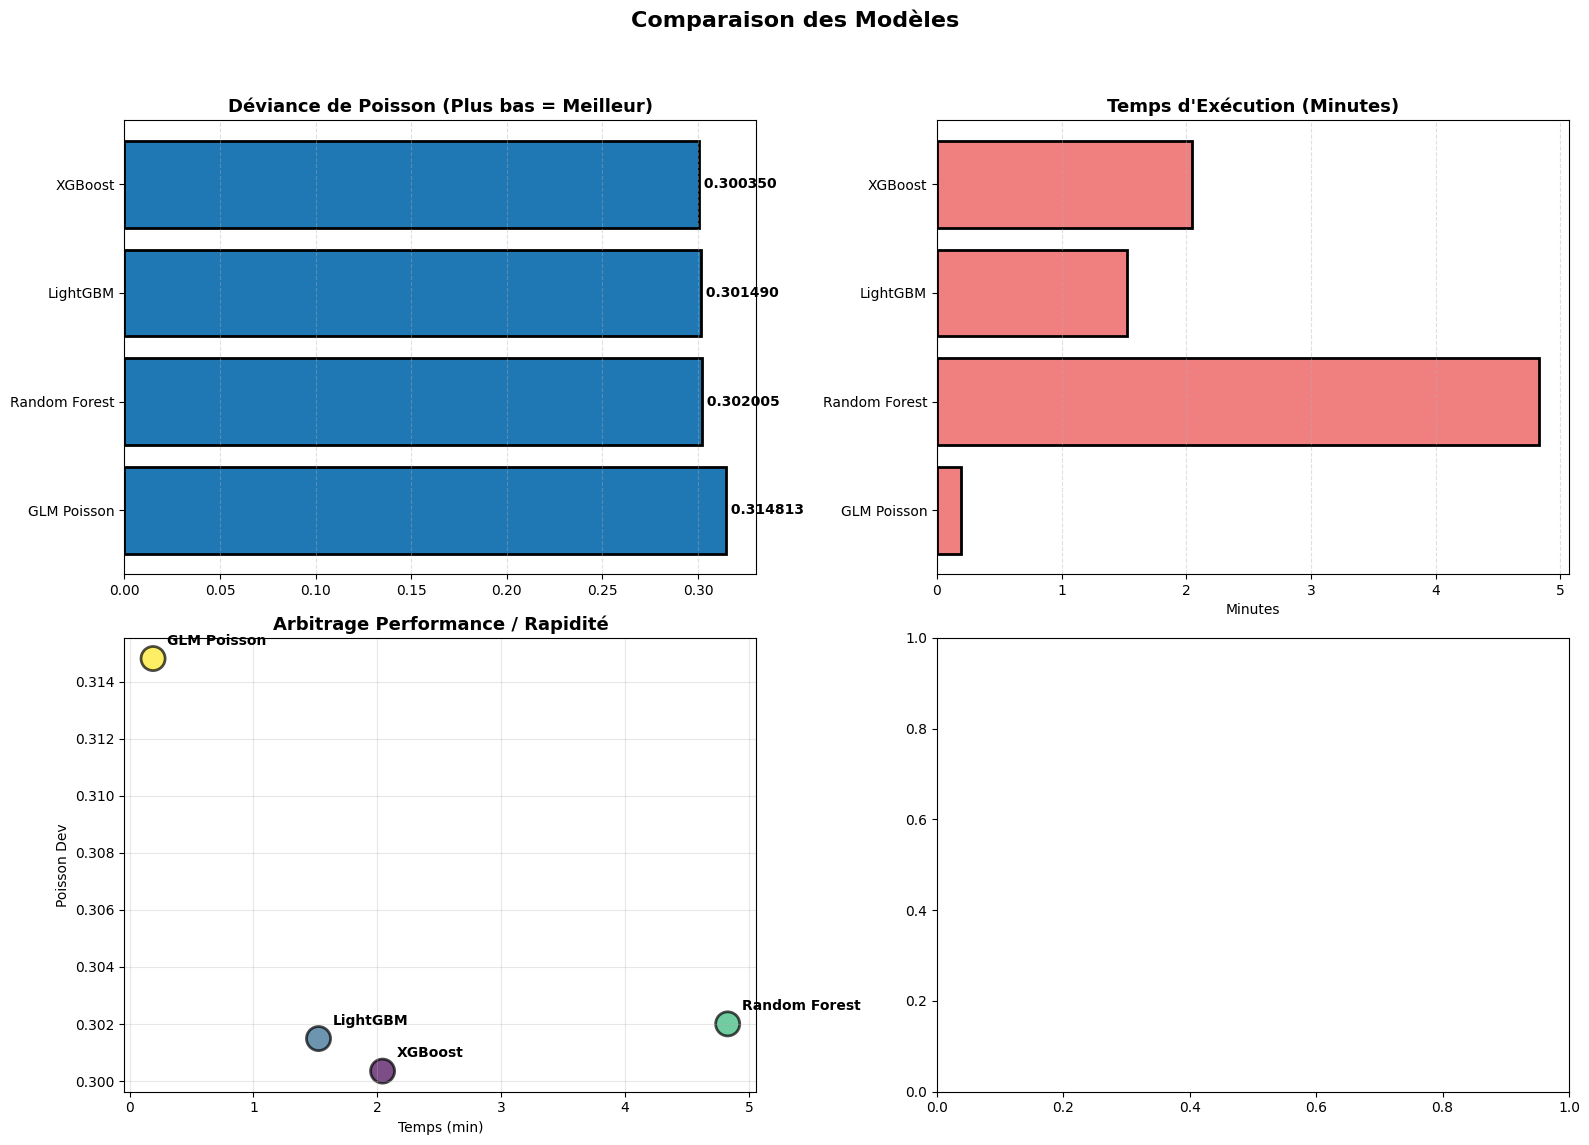

In [91]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparaison des Modèles', fontsize=16, fontweight='bold')

ax1 = axes[0, 0]
models = comparison_freq['Modèle'].values
dev_values = comparison_freq['Poisson Dev (CV)'].values

bars = ax1.barh(models, dev_values, edgecolor='black', linewidth=2)
ax1.set_title('Déviance de Poisson (Plus bas = Meilleur)', fontsize=13, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', linestyle='--', alpha=0.4)

for bar, val in zip(bars, dev_values):
    ax1.text(bar.get_width(), bar.get_y() + bar.get_height()/2.,
             f' {val:.6f}', ha='left', va='center', fontweight='bold')

ax2 = axes[0, 1]
times = comparison_freq['Temps (min)'].values
bars2 = ax2.barh(models, times, color='lightcoral', edgecolor='black', linewidth=2)
ax2.set_title('Temps d\'Exécution (Minutes)', fontsize=13, fontweight='bold')
ax2.invert_yaxis()
ax2.set_xlabel('Minutes')
ax2.grid(axis='x', linestyle='--', alpha=0.4)

ax3 = axes[1, 0]
ax3.scatter(times, dev_values, s=300, c=range(len(models)), cmap='viridis', 
            edgecolor='black', linewidth=2, alpha=0.7)

for i, txt in enumerate(models):
    ax3.annotate(txt, (times[i], dev_values[i]), xytext=(10, 10), 
                 textcoords='offset points', fontweight='bold')

ax3.set_title('Arbitrage Performance / Rapidité', fontsize=13, fontweight='bold')
ax3.set_xlabel('Temps (min)')
ax3.set_ylabel('Poisson Dev')
ax3.grid(alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 6.2 Comparaison modèle sévérité

In [92]:
print(f"\n" + "="*80)
print("GRIDSEARCHCV - SÉVÉRITÉ (XGBoost Gamma)")
print("="*80)


param_grid_xgb_sev = {
    'max_depth': [3, 4,5],
    'n_estimators': [310,320,330],
    'learning_rate': [0.015,0.02,0.025],
    'min_child_weight': [35,40,45],
    'colsample_bytree': [0.3,0.35]
}

model_xgb_sev = xgb.XGBRegressor(
    objective='reg:gamma',
    eval_metric='gamma-nloglik',
    tree_method='hist',
    random_state=42,
    verbosity=0
)

model_xgb_sev.set_fit_request(sample_weight=True)

grid_sev_xgb = GridSearchCV(
    estimator=model_xgb_sev,
    param_grid=param_grid_xgb_sev,
    cv=kf,
    scoring=scoring_sev,
    refit='D2_Gamma',
    n_jobs=-1,
    verbose=2
)

print(f"\n Lancement GridSearchCV pour SÉVÉRITÉ (XGBoost)...")
print("\n" + "─"*80)

start_time = time.time()
grid_sev_xgb.fit(X_train_sev_final, y_train_sev, sample_weight=weights_train_sev)
elapsed_sev_xgb = time.time() - start_time

print("─"*80)
print(f"\n GridSearchCV SÉVÉRITÉ terminé en {elapsed_sev_xgb:.1f}s")

print(f"\n MEILLEURS HYPERPARAMÈTRES (Sévérité XGBoost) :")
print("─"*80)
for param, value in grid_sev_xgb.best_params_.items():
    print(f"   {param:20} : {value}")

print(f"\n RÉSULTATS RÉELS (Validation Croisée) :")
print("─"*80)

d2_score = grid_sev_xgb.best_score_
print(f"   D2 Gamma (Score) : {d2_score:.4%} ")


best_index = grid_sev_xgb.best_index_
mae_score = -grid_sev_xgb.cv_results_['mean_test_MAE'][best_index]
print(f"   MAE (Erreur Moy) : {mae_score:,.2f}€")

xgb_sev_result = {
    'Modèle': 'XGBoost Gamma',
    'Grid': param_grid_xgb_sev,
    'Elapsed': elapsed_sev_xgb,
    'Best_D2': d2_score,
    'Best_MAE': mae_score 
}



GRIDSEARCHCV - SÉVÉRITÉ (XGBoost Gamma)

 Lancement GridSearchCV pour SÉVÉRITÉ (XGBoost)...

────────────────────────────────────────────────────────────────────────────────
Fitting 5 folds for each of 162 candidates, totalling 810 fits
────────────────────────────────────────────────────────────────────────────────

 GridSearchCV SÉVÉRITÉ terminé en 27.1s

 MEILLEURS HYPERPARAMÈTRES (Sévérité XGBoost) :
────────────────────────────────────────────────────────────────────────────────
   colsample_bytree     : 0.3
   learning_rate        : 0.02
   max_depth            : 3
   min_child_weight     : 35
   n_estimators         : 310

 RÉSULTATS RÉELS (Validation Croisée) :
────────────────────────────────────────────────────────────────────────────────
   D2 Gamma (Score) : 1.3706% 
   MAE (Erreur Moy) : 1,279.30€


In [93]:
print(f"\n" + "="*80)
print("GRIDSEARCHCV - SÉVÉRITÉ (LightGBM Gamma)")
print("="*80)

param_grid_lgb_sev = {
    'learning_rate': [0.01, 0.05, 0.1], 
    'n_estimators': [300,400,500],
    'max_depth': [3, 5],             
    'num_leaves': [15, 31,50],             
    'min_child_samples': [20, 50],
    'reg_alpha': [0.1],              
    'reg_lambda': [0]
}

lgb_sev = lgb.LGBMRegressor(
    objective='gamma',
    random_state=42,
    verbosity=-1,
    n_jobs=-1,    
    device='gpu',   
    gpu_platform_id=0,
    gpu_device_id=0,
    max_bin=63     
)

lgb_sev.set_fit_request(sample_weight=True)

grid_sev_lgb = GridSearchCV(
    estimator=lgb_sev,
    param_grid=param_grid_lgb_sev,
    cv=kf,
    scoring=scoring_sev,
    refit='D2_Gamma',    
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

print(f"\n⏳ Lancement GridSearchCV pour SÉVÉRITÉ (LightGBM)...")
print("\n" + "─"*80)

start_time = time.time()

grid_sev_lgb.fit(X_train_sev_final, y_train_sev, sample_weight=weights_train_sev)

elapsed_sev_lgb = time.time() - start_time

print("─"*80)
print(f"GridSearchCV SÉVÉRITÉ (LightGBM) terminé en {elapsed_sev_lgb:.1f}s")

print(f"\n MEILLEURS HYPERPARAMÈTRES :")
print("─"*80)
for param, value in grid_sev_lgb.best_params_.items():
    print(f"   {param:20} : {value}")

print(f"\n RÉSULTATS RÉELS (Validation Croisée) :")
print("─"*80)


d2_score = grid_sev_lgb.best_score_
print(f"   D2 Gamma (Score)     : {d2_score:.4%}")

best_idx = grid_sev_lgb.best_index_
mae_score = -grid_sev_lgb.cv_results_['mean_test_MAE'][best_idx]

print(f"   MAE (Erreur Moyenne) : {mae_score:,.2f}€")


lgb_sev_result = {
    'Modèle': 'LightGBM Gamma',
    'Grid': grid_sev_lgb,
    'Elapsed': elapsed_sev_lgb,
    'Best_D2': d2_score,
    'Best_MAE': mae_score 
}


GRIDSEARCHCV - SÉVÉRITÉ (LightGBM Gamma)

⏳ Lancement GridSearchCV pour SÉVÉRITÉ (LightGBM)...

────────────────────────────────────────────────────────────────────────────────
Fitting 5 folds for each of 108 candidates, totalling 540 fits
────────────────────────────────────────────────────────────────────────────────
GridSearchCV SÉVÉRITÉ (LightGBM) terminé en 437.7s

 MEILLEURS HYPERPARAMÈTRES :
────────────────────────────────────────────────────────────────────────────────
   learning_rate        : 0.01
   max_depth            : 3
   min_child_samples    : 20
   n_estimators         : 300
   num_leaves           : 15
   reg_alpha            : 0.1
   reg_lambda           : 0

 RÉSULTATS RÉELS (Validation Croisée) :
────────────────────────────────────────────────────────────────────────────────
   D2 Gamma (Score)     : 1.1112%
   MAE (Erreur Moyenne) : 1,283.07€


In [94]:
print(f"\n" + "="*80)
print("GRIDSEARCHCV - GLM GAMMA (Sévérité)")
print("="*80)

param_grid_glm_sev = {
    'alpha': [0, 0.008, 0.01, 0.012, 0.015], 
    'solver': ['lbfgs'], 
    'tol': [1e-4, 1e-6, 1e-7],
    'max_iter': [100,150,200,250,300]
}

grid_sev_glm = GridSearchCV(
    estimator=GammaRegressor(),
    param_grid=param_grid_glm_sev,
    cv=kf,
    scoring=scoring_sev,
    refit='D2_Gamma', 
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

print(f"\n⏳ Lancement GridSearchCV GLM Gamma...")
print("\n" + "─"*80)

start_time = time.time()
grid_sev_glm.fit(X_train_sev_final, y_train_sev)
elapsed_sev_glm = time.time() - start_time

print("─"*80)
print(f"GridSearchCV SÉVÉRITÉ (GLM Gamma) terminé en {elapsed_sev_glm:.1f}s")

print(f"\n MEILLEURS HYPERPARAMÈTRES :")
print("─"*80)
for param, value in grid_sev_glm.best_params_.items():
    print(f"   {param:20} : {value}")

print(f"\n RÉSULTATS RÉELS (Validation Croisée) :")
print("─"*80)

d2_score = grid_sev_glm.best_score_
print(f"   D2 Gamma (Score)     : {d2_score:.4%}")

best_idx = grid_sev_glm.best_index_
mae_score = -grid_sev_glm.cv_results_['mean_test_MAE'][best_idx]
print(f"   MAE (Erreur Moyenne) : {mae_score:,.2f}€")

train_mse = -grid_sev_glm.cv_results_['mean_train_MSE'][best_idx]
test_mse = -grid_sev_glm.cv_results_['mean_test_MSE'][best_idx]
ratio = test_mse / train_mse

print(f"\n Analyse overfitting :")
print(f"   Train MSE : {train_mse:,.0f}")
print(f"   Test MSE  : {test_mse:,.0f}")
print(f"   Ratio     : {ratio:.3f}")

glm_sev_result = {
    'Modèle': 'GLM Gamma',
    'Grid': grid_sev_glm,
    'Elapsed': elapsed_sev_glm,
    'Best_D2': d2_score,
    'Best_MAE': mae_score
}


GRIDSEARCHCV - GLM GAMMA (Sévérité)

⏳ Lancement GridSearchCV GLM Gamma...

────────────────────────────────────────────────────────────────────────────────
Fitting 5 folds for each of 75 candidates, totalling 375 fits
────────────────────────────────────────────────────────────────────────────────
GridSearchCV SÉVÉRITÉ (GLM Gamma) terminé en 6.2s

 MEILLEURS HYPERPARAMÈTRES :
────────────────────────────────────────────────────────────────────────────────
   alpha                : 0
   max_iter             : 300
   solver               : lbfgs
   tol                  : 0.0001

 RÉSULTATS RÉELS (Validation Croisée) :
────────────────────────────────────────────────────────────────────────────────
   D2 Gamma (Score)     : 0.9344%
   MAE (Erreur Moyenne) : 1,177.92€

 Analyse overfitting :
   Train MSE : 5,546,737
   Test MSE  : 5,554,051
   Ratio     : 1.001


In [95]:
results_sev = []

def get_best_metrics_sev(grid_result, model_name, elapsed_time):
    best_idx = grid_result.best_index_
    mse_cv = -grid_result.cv_results_['mean_test_MSE'][best_idx]
    rmse_cv = np.sqrt(mse_cv)
    mae_cv = -grid_result.cv_results_['mean_test_MAE'][best_idx]
    dev_cv = -grid_result.cv_results_['mean_test_Gamma_Dev'][best_idx]
    
    return {
        'Modèle': model_name,
        'RMSE (CV)': rmse_cv,
        'MAE (CV)': mae_cv,
        'Gamma Dev (CV)': dev_cv,
        'Temps (min)': elapsed_time / 60
    }

results_sev.append(get_best_metrics_sev(grid_sev_glm, 'GLM Gamma', elapsed_sev_glm))
results_sev.append(get_best_metrics_sev(grid_sev_xgb, 'XGBoost', elapsed_sev_xgb))
results_sev.append(get_best_metrics_sev(grid_sev_lgb, 'LightGBM', elapsed_sev_lgb))

comparison_sev = pd.DataFrame(results_sev)

comparison_sev = comparison_sev.sort_values('Gamma Dev (CV)').reset_index(drop=True)

print("TABLEAU DE COMPARAISON DES MODÈLES (SÉVÉRITÉ)")
display(comparison_sev)

TABLEAU DE COMPARAISON DES MODÈLES (SÉVÉRITÉ)


,Modèle,RMSE (CV),MAE (CV),Gamma Dev (CV),Temps (min)
0,GLM Gamma,2356.703439,1177.917769,1.042545,0.104133
1,XGBoost,2491.112734,1279.297817,NaN,0.451444
2,LightGBM,2493.028848,1283.068307,NaN,7.295762



GÉNÉRATION DES VISUALISATIONS


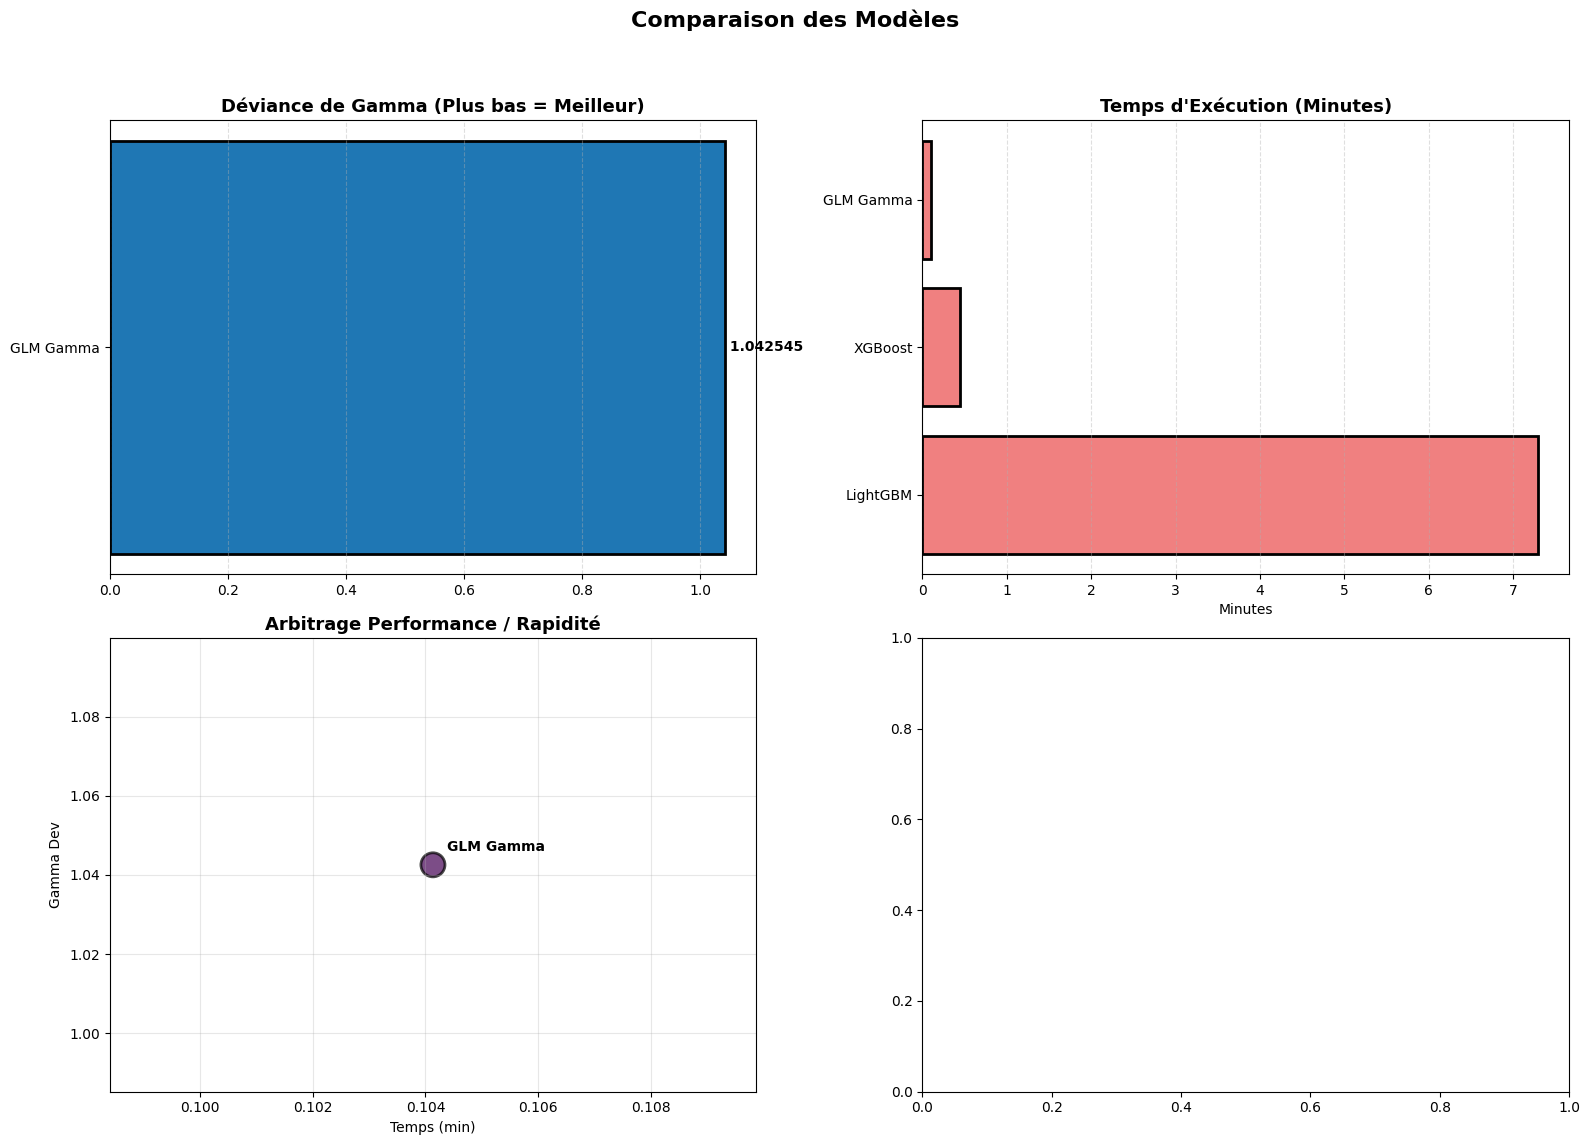

In [96]:
print(f"\n" + "="*80)
print("GÉNÉRATION DES VISUALISATIONS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparaison des Modèles', fontsize=16, fontweight='bold')

ax1 = axes[0, 0]
models = comparison_sev['Modèle'].values
dev_values = comparison_sev['Gamma Dev (CV)'].values

bars = ax1.barh(models, dev_values, edgecolor='black', linewidth=2)
ax1.set_title('Déviance de Gamma (Plus bas = Meilleur)', fontsize=13, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', linestyle='--', alpha=0.4)

for bar, val in zip(bars, dev_values):
    ax1.text(bar.get_width(), bar.get_y() + bar.get_height()/2.,
             f' {val:.6f}', ha='left', va='center', fontweight='bold')

ax2 = axes[0, 1]
times = comparison_sev['Temps (min)'].values
bars2 = ax2.barh(models, times, color='lightcoral', edgecolor='black', linewidth=2)
ax2.set_title('Temps d\'Exécution (Minutes)', fontsize=13, fontweight='bold')
ax2.invert_yaxis()
ax2.set_xlabel('Minutes')
ax2.grid(axis='x', linestyle='--', alpha=0.4)

ax3 = axes[1, 0]
ax3.scatter(times, dev_values, s=300, c=range(len(models)), cmap='viridis', 
            edgecolor='black', linewidth=2, alpha=0.7)

for i, txt in enumerate(models):
    ax3.annotate(txt, (times[i], dev_values[i]), xytext=(10, 10), 
                 textcoords='offset points', fontweight='bold')

ax3.set_title('Arbitrage Performance / Rapidité', fontsize=13, fontweight='bold')
ax3.set_xlabel('Temps (min)')
ax3.set_ylabel('Gamma Dev')
ax3.grid(alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 8. Choix des modèles

A travers ces comparaisons, nosu avons vu que le modèle de machine learning LightGBM présente les meilleurs résultats que ce soit en Fréquence ou en Sévérité, on va donc modéliser par rapport à ces modèles, de plus, les modèles classiques utilisés en actuariat sont le GLM Poisson et le GLM Gamma, nious allons donc aussi les utiliser pour modéliser.

In [97]:
X_test_sev_transformed = preprocessor_sev.transform(X_test_freq) 

freq_pred = grid_freq_lgb.best_estimator_.predict(X_test_freq_final)
sev_pred = grid_sev_xgb.best_estimator_.predict(X_test_sev_transformed)

pure_premium_pred = freq_pred * sev_pred

y_true_total = df_test['ClaimAmount'].values

print(f"Dimensions Fréquence : {X_test_freq_final.shape}")
print(f"Dimensions Sévérité  : {X_test_sev_transformed.shape}")

Dimensions Fréquence : (135337, 20)
Dimensions Sévérité  : (135337, 12)


In [98]:
total_brut = df_train['ClaimAmount'].sum()
total_cappe = y_train_capped.sum() 

factor = total_brut / total_cappe

print(f"Total Brut : {total_brut:,.0f} €")
print(f"Total Cappé : {total_cappe:,.0f} €")
print(f"Facteur de redressement : {factor:.4f}")

Total Brut : 49,096,420 €
Total Cappé : 32,824,920 €
Facteur de redressement : 1.4957


In [99]:
pure_premium_final = (freq_pred * sev_pred) * factor

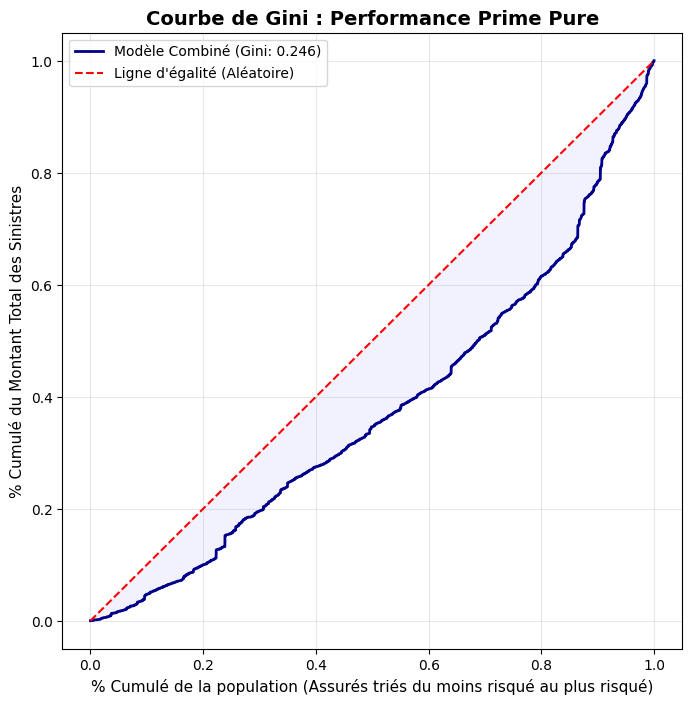

In [100]:
def plot_gini_premium(y_true, y_pred):
    df_gini = pd.DataFrame({'true': y_true, 'pred': y_pred})
    df_gini = df_gini.sort_values('pred').reset_index(drop=True)
    n = len(df_gini)
    cum_pop = np.arange(0, n + 1) / n
    cum_true = np.insert(df_gini['true'].cumsum().values, 0, 0)
    cum_true = cum_true / cum_true[-1]
    area_auc = np.trapz(cum_true, cum_pop)
    gini_index = 2 * (0.5 - area_auc)
    plt.figure(figsize=(8, 8))
    plt.plot(cum_pop, cum_true, label=f'Modèle Combiné (Gini: {gini_index:.3f})', color='darkblue', lw=2)
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Ligne d\'égalité (Aléatoire)')
    plt.title('Courbe de Gini : Performance Prime Pure', fontsize=14, fontweight='bold')
    plt.xlabel('% Cumulé de la population (Assurés triés du moins risqué au plus risqué)', fontsize=11)
    plt.ylabel('% Cumulé du Montant Total des Sinistres', fontsize=11)
    plt.fill_between(cum_pop, cum_pop, cum_true, color='blue', alpha=0.05)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

plot_gini_premium(y_true_total, pure_premium_final)

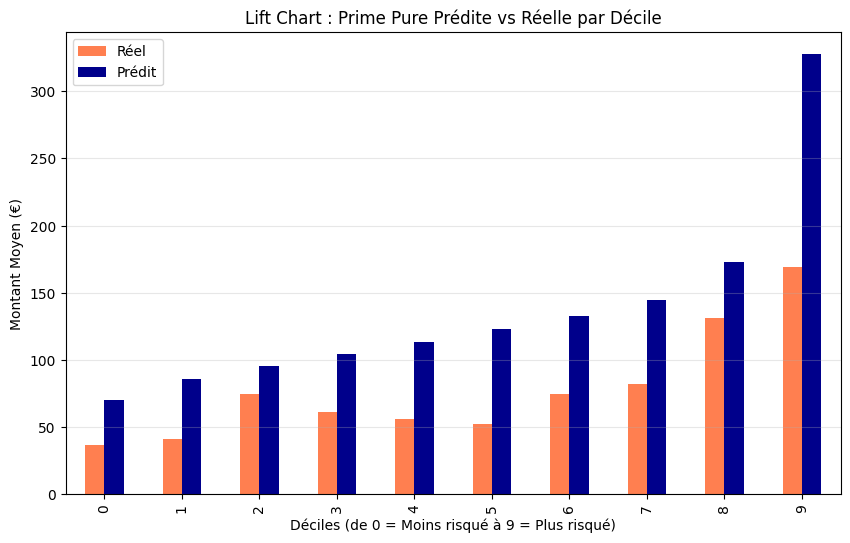

In [101]:
def plot_lift_chart(y_true, y_pred):
    df_lift = pd.DataFrame({'Reel': y_true, 'Pred': y_pred})
    df_lift['Decile'] = pd.qcut(df_lift['Pred'], 10, labels=False)
    lift_data = df_lift.groupby('Decile').agg({'Reel': 'mean', 'Pred': 'mean'})
    lift_data.plot(kind='bar', figsize=(10, 6), color=['coral', 'darkblue'])
    plt.title('Lift Chart : Prime Pure Prédite vs Réelle par Décile')
    plt.ylabel('Montant Moyen (€)')
    plt.xlabel('Déciles (de 0 = Moins risqué à 9 = Plus risqué)')
    plt.legend(['Réel', 'Prédit'])
    plt.grid(axis='y', alpha=0.3)
    plt.show()

plot_lift_chart(y_true_total, pure_premium_final)

In [102]:
total_sinistres_reels = y_true_total.sum()
total_primes_encaissees = pure_premium_final.sum()

ratio_sp = (total_sinistres_reels / total_primes_encaissees) * 100

print(f"="*50)
print(f"BILAN FINANCIER DU PORTEFEUILLE")
print(f"="*50)
print(f"Total Sinistres Réels : {total_sinistres_reels:,.0f} €")
print(f"Total Primes Prédites : {total_primes_encaissees:,.0f} €")
print(f"Ratio S/P Global     : {ratio_sp:.2f} %")
print(f"="*50)

BILAN FINANCIER DU PORTEFEUILLE
Total Sinistres Réels : 10,553,217 €
Total Primes Prédites : 18,546,712 €
Ratio S/P Global     : 56.90 %


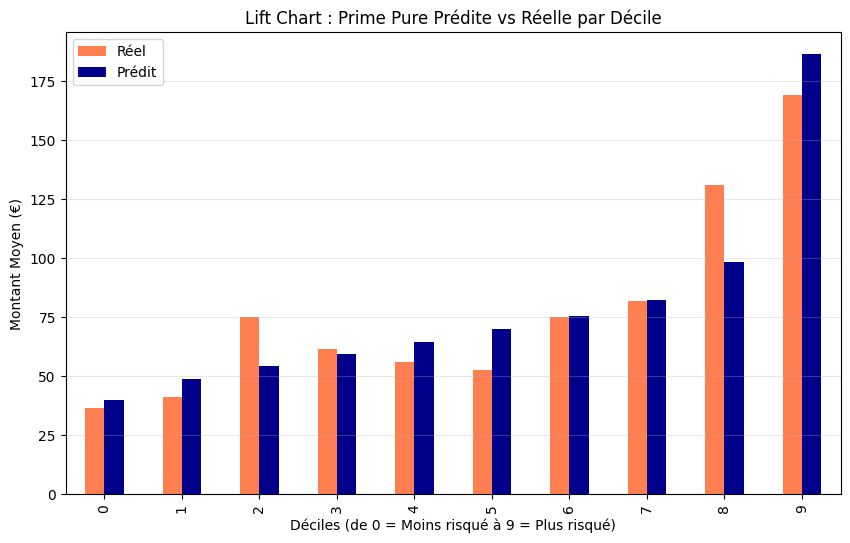

In [103]:
ratio_sp = y_true_total.sum() / pure_premium_final.sum()
pure_premium_calib = pure_premium_final * ratio_sp
plot_lift_chart(y_true_total, pure_premium_calib)

In [104]:
y_true_capped = df_test['ClaimAmount'].clip(upper=seuil_capping).values

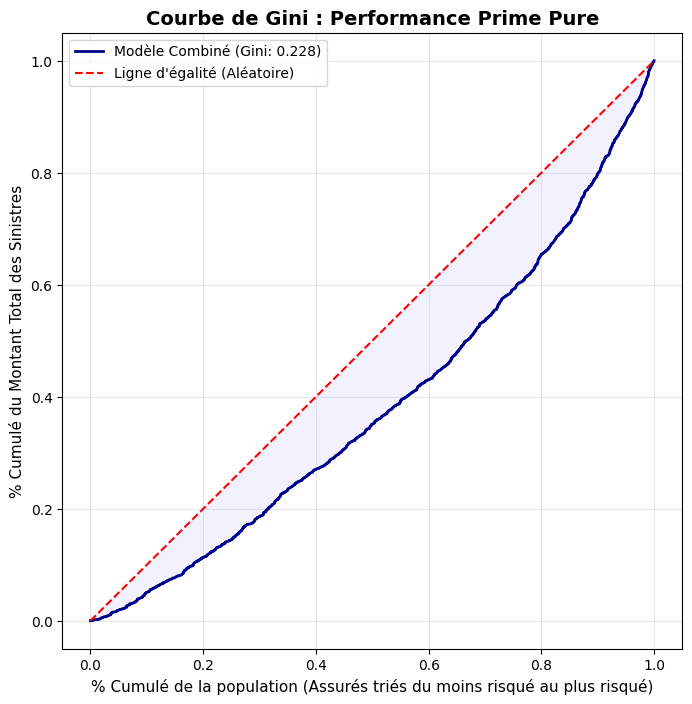

In [105]:
plot_gini_premium(y_true_capped, pure_premium_pred)

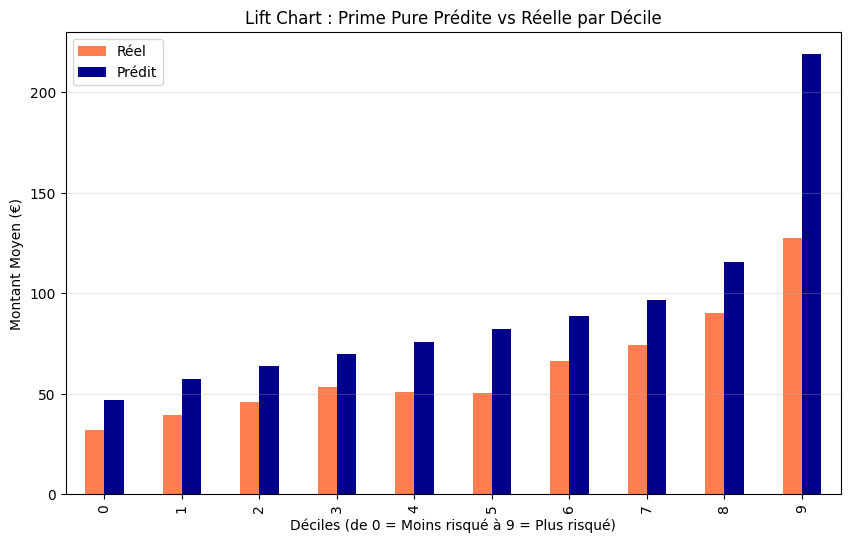

In [106]:
plot_lift_chart(y_true_capped, pure_premium_pred)

Ratio de recalibrage (Cappe) : 0.6868


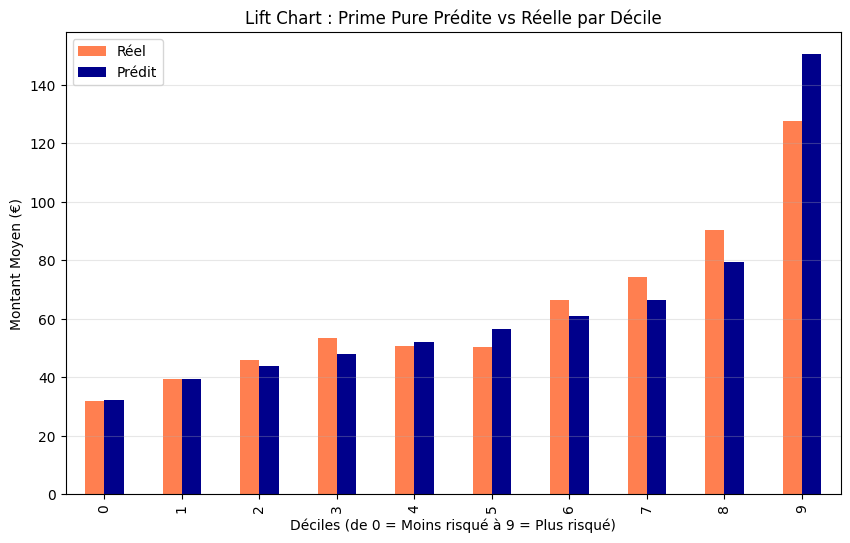

In [107]:
ratio_test_capped = y_true_capped.sum() / pure_premium_pred.sum()

pure_premium_calib_capped = pure_premium_pred * ratio_test_capped

print(f"Ratio de recalibrage (Cappe) : {ratio_test_capped:.4f}")

plot_lift_chart(y_true_capped, pure_premium_calib_capped)

In [108]:
ratio_recalibrage = y_true_total.sum() / pure_premium_pred.sum()
pure_premium_finale = pure_premium_pred * ratio_recalibrage

sp_avant = (y_true_total.sum() / pure_premium_pred.sum()) * 100
sp_apres = (y_true_total.sum() / pure_premium_finale.sum()) * 100

print(f"="*60)
print(f"BILAN TECHNIQUE ET FINANCIER")
print(f"="*60)
print(f"Total Primes (Après recalibrage) : {pure_premium_finale.sum():,.0f} €")
print(f"Ratio S/P Final       : {sp_apres:.2f} %")
print(f"="*60)

BILAN TECHNIQUE ET FINANCIER
Total Primes (Après recalibrage) : 10,553,217 €
Ratio S/P Final       : 100.00 %


Dans ce lift Chart, on comprend que notre modèle a beaucoup de mal a évalué les sinistres  présentant un grand risque, cela peut être dû à la présence de sinistres à plus de 1M euros, qui biaise totalement notre modèle sévérité.

## 9. Equité algorithmique

In [109]:
sensitive_feature = df_test['Area'].apply(lambda x: 'Zone_Urbaine_F' if x == 'F' else 'Autres_Zones')

metrics = {
    'Prime Moyenne (€)': lambda y_true, y_pred: np.mean(y_pred),
    'MAE (€)': mean_absolute_error,
    'Effectif': lambda y_true, y_pred: len(y_pred)
}

mf = MetricFrame(
    metrics=metrics,
    y_true=y_true_total,
    y_pred=pure_premium_final,
    sensitive_features=sensitive_feature
)

print("="*60)
print("RÉSULTATS DE FAIRNESS")
print("="*60)
print(mf.by_group)
print("-" * 60)

group_means = mf.by_group['Prime Moyenne (€)']
ratio_disparite = group_means.max() / group_means.min()
print(f"Ratio de disparité des primes : {ratio_disparite:.2f}")

RÉSULTATS DE FAIRNESS
                Prime Moyenne (€)     MAE (€)  Effectif
Area                                                   
Autres_Zones           136.535844  203.427142  131741.0
Zone_Urbaine_F         155.545882  193.027102    3596.0
------------------------------------------------------------
Ratio de disparité des primes : 1.14


In [110]:
metrics = {
    'Prime Moyenne (€)': lambda y_true, y_pred: np.mean(y_pred),
    'MAE (€)': mean_absolute_error,
    'Effectif': lambda y_true, y_pred: len(y_pred)
}

mf_age = MetricFrame(
    metrics=metrics,
    y_true=y_true_total,
    y_pred=pure_premium_final,
    sensitive_features=df_test['DrivAge_Bin']
)

print("="*60)
print("AUDIT D'ÉQUITÉ : TRANCHES D'ÂGE")
print("="*60)
print(mf_age.by_group)
print("-" * 60)

AUDIT D'ÉQUITÉ : TRANCHES D'ÂGE
             Prime Moyenne (€)     MAE (€)  Effectif
DrivAge_Bin                                         
18-21               216.320199  398.520549    2203.0
22-25               189.868919  259.642334    5400.0
26-35               119.861135  189.130844   29954.0
36-55               133.724100  194.665388   66294.0
56-70               136.916910  183.367927   23620.0
70+                 172.319188  293.959861    7866.0
------------------------------------------------------------
